In [2]:
import scipy.stats as stats
from scipy import special
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import colormaps
from scipy.stats.mstats import trim as trim
# from utils import *
%pip install ipynb
from ipynb.fs.full.extractor_ARs import *
from ipynb.fs.full.UN_ARs import *
from ipynb.fs.full.utilities import *


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## Part 1: utilities

This is a set of utility functions: transpositions and count occurrencies

In [3]:
path_for_figure = os.path.join(os.getcwd(),"figures_population_paper")
osExists = os.path.exists(path_for_figure)

if not osExists:
    os.makedirs(path_for_figure)

## Part 2: data loading

The first block below uploads the IPCC databases, AR5 (ar5HI), SR 1.5 (ar15HI), and AR6 (ar6HI). 
In AR6, the 5-region, 6-region, and 10-region version of AR6 are uploaded.

The second block below uploads the United Nation (UN) probabilistic projections:
'- w#, r#, and o# map the global, the regional, and the "rest of the world" region in the UN data
'- the suffix 20XY defines the year of the probabilistic projction revision
'- the suffix #_1, #_5, #_6, #_10 refers to the number of regions of the IPCC into which countries are mapped
'- w2022_1hist represents historical year projection from UN, it offers a 5-year population projection from 2010 to 2025

The third block below uploads the United Nation population scnearions (deterministic), following the same rules for suffixes as the probabilisic projections.
'- w2015_1ext, w2019_1ext, w2022_1ext are the global probabilistic projection of the United Nations, including the highest and lowest deterministic scenarios.


World databases are displayed in billion

In [4]:
years = [2020, 2030, 2040, 2050, 2060, 2070,
            2080, 2090, 2100]

ar5HI, ar15HI, ar6HI = nonharmARsextractor("data")

ar5HI.Region = ar5HI.Region.replace("MAF", "R5MAF")
ar5HI.Region = ar5HI.Region.replace("REF", "R5REF")
ar5HI.Region = ar5HI.Region.replace("LAM", "R5LAM")
ar5HI.Region = ar5HI.Region.replace("OECD90", "R5OECD90+EU")
ar5HI.Region = ar5HI.Region.replace("ASIA", "R5ASIA")
ar5HI.Region = ar5HI.Region.replace("World", "WORLD")
ar6HI.Region = ar6HI.Region.replace("World", "WORLD")
ar15HI.Region = ar15HI.Region.replace("World", "WORLD")

ar6reg5HI, ar6reg6HI, ar6reg10HI = nonharmARregsextractor("data")

In [5]:
years = [2020, 2030, 2040, 2050, 2060, 2070,
            2080, 2090, 2100]

filenames =["UN_PPP2015_Output_PopTot_Probabilistic.xls",
            "UN_PPP2017_Output_PopTot_Probabilistic.xls",
            "UN_PPP2019_Output_PopTot_Probabilistic.xlsx",
            "UN_PPP2022_Output_PopTot_Probabilistic.xlsx"]


w2015_1, r2015_1, o2015_1 = un_tseries(years, filenames[0], 1, True, [])
w2017_1, r2017_1, o2017_1 = un_tseries(years, filenames[1], 1, True, [])
w2019_1, r2019_1, o2019_1 = un_tseries(years, filenames[2], 1, True, [])
w2022_1, r2022_1, o2022_1 = un_tseries2022 (years, filenames[3], 1, True, [])

w2015_6, r2015_6, o2015_6 = un_tseries(years, filenames[0], 6, True, [])
w2017_6, r2017_6, o2017_6 = un_tseries(years, filenames[1], 6, True, [])
w2019_6, r2019_6, o2019_6 = un_tseries(years, filenames[2], 6, True, [])
w2022_6, r2022_6, o2022_6 = un_tseries2022 (years, filenames[3], 6, True, [])

w2015_5, r2015_5, o2015_5 = un_tseries(years, filenames[0], 5, True, [])
w2017_5, r2017_5, o2017_5 = un_tseries(years, filenames[1], 5, True, [])
w2019_5, r2019_5, o2019_5 = un_tseries(years, filenames[2], 5, True, [])
w2022_5, r2022_5, o2022_5 = un_tseries2022 (years, filenames[3], 5, True, [])

w2015_10, r2015_10, o2015_10 = un_tseries(years, filenames[0], 10, True, [])
w2017_10, r2017_10, o2017_10 = un_tseries(years, filenames[1], 10, True, [])
w2019_10, r2019_10, o2019_10 = un_tseries(years, filenames[2], 10, True, [])
w2022_10, r2022_10, o2022_10 = un_tseries2022 (years, filenames[3], 10, True, [])


hist_years =  np.arange(2000, 2025,5)
numregions = 1
filename = "WPP2022_GEN_F01_DEMOGRAPHIC_INDICATORS_REV1.xlsx"
w2022_1hist = un_reading_historical(hist_years, filename, 1, True, [])

In [6]:
wyears=un_extraction("WORLD", years) # this extractor gives columns as float rather than strings
syears = [str(y) for y in years if years != 2020]
year_rename = dict(zip(syears,years))
wyears=wyears.rename(columns=year_rename)

wversion = wyears.copy(deep=True)
# sel_versions = ['revision_2015', 'revision_2019', 'revision_2022']
# wversion = pd.DataFrame(wyears.loc[wyears.Variant.isin(sel_versions)])

# add 2020
wversion.loc[(wversion.Region=="WORLD")& (wversion.Variant=="revision_2022"), 2020] = pd.Series(np.unique(w2022_1[2020].values))

# add deterministic "Variant" to probabilistic databases
w2022_1["Variant"] = "revision_2022"
w2019_1["Variant"] = "revision_2019"
w2015_1["Variant"] = "revision_2015"

wversion.loc[wversion.Region=="WORLD", "IPCCRegion"] = wversion["Region"]
wversion = wversion.rename(columns={"Region": "UNRegion"})
columns = ["IPCCRegion", "Scenario", "Variant", "UNRegion", 2020, 2030, 2040, 2050, 2060, 2070, 2080, 2090, 2100]
w2022_1 = w2022_1[columns]
w2019_1 = w2019_1[columns]
w2015_1 = w2015_1[columns]
wversion = wversion[columns]

# Define extended databases with the external scenarios to probabilistic
w2022_1ext = pd.DataFrame(wversion.loc[wversion.Variant=="revision_2022"])
w2019_1ext = pd.DataFrame(wversion.loc[wversion.Variant=="revision_2019"])
w2015_1ext = pd.DataFrame(wversion.loc[wversion.Variant=="revision_2015"])


## Local regions

In [7]:
years = [2020, 2030, 2040, 2050, 2060, 2070,
            2080, 2090, 2100]

# Extract UN deterministic for selected regions
sel_variant = "revision_2022"


regnames = [["Small Island Developing States (SIDS)"], ["Least developed countries"],  ["Land-locked Developing Countries (LLDC)"]]
shortnames = ["SIDs", "LDCs", "LLDCs"]

remove_scenarios = ['Constant-fertility', 'Instant-replacement', 'Instant-replacement zero migr', 'No change', 'Momentum']


regext = pd.DataFrame()
for r,region in enumerate(regnames):
    # extract all variants
    allvdata = un_extraction (regnames[r][0], years)
    allvdata["Region"] = shortnames[r]
    allvdata = allvdata.rename(columns={"Region": "UNRegion"})
    for y in years:
        allvdata = allvdata.rename(columns={str(y): y })
    allvdata["IPCCRegion"] = shortnames[r]
    allvdata = allvdata[w2022_1ext.columns].ffill()
    ff = pd.DataFrame(allvdata.loc[allvdata.Variant==sel_variant])
    data = transformUNminmax(ff, shortnames[r], False, remove_scenarios)[0]
    data["Region"] = shortnames[r]
    data["Variant"] = "Deterministic"
    regext = pd.concat((regext, data))

# Extract probabilistic profiles for selected regions
filename = "UN_PPP2022_Output_PopTot_Probabilistic.xlsx"


probdata = pd.DataFrame()
for r, region in enumerate(regnames):
    data = un_tseries2022(years, filename, 1, False, regnames[r])[0]
    data["UNRegion"] = shortnames[r]
    data["IPCCRegion"] = shortnames[r]
    data["Variant"] = "Probabilistic"
    data = data[list(w2022_1ext.columns)]
    probdata = pd.concat((probdata, data))

# dataFrame with regional probabilistic values
regprob = pd.DataFrame()
for r, region in enumerate(shortnames):
    indata = pd.DataFrame(probdata.loc[probdata.UNRegion==region])
    data = transformUN(indata=indata, region= region, rename=True)
    data["Region"] = region
    data["Variant"] = "Probabilistic"
    regprob = pd.concat( (regprob, data) )




## Read from SSPs

In [8]:
regssp, groups = readSSP(years)[0], readSSP(years)[4]
dict_sids = createsids()
dict_ldcs = createldcs()
dict_lldcs = createlldcs()

In [9]:
dict_list = [dict_sids, dict_ldcs, dict_lldcs]

allssp = pd.DataFrame()
for r, rex in enumerate(shortnames):
    regions = [k for k in dict_list[r][rex]]
    data = pd.DataFrame(regssp[regssp.REGION.isin(regions)]).groupby(["MODEL", "SCENARIO"]).sum().reset_index()
    data = data.groupby(["SCENARIO"]).mean([years]).reset_index()

    data["REGION"] = rex
    data["Country"] = rex
    data["VARIABLE"] = "Population"
    data["UNIT"] = "million"
    data["Variant"] = "SSP"

    rename_columns = {"REGION": "UNRegion", "Country": "IPCCRegion", "VARIABLE": "Variable", "UNIT": "Unit", "SCENARIO": "Scenario"}
    rename_years = {k: v for k, v in zip([str(y) for y in years], years)}

    data = data.rename(columns=rename_columns)
#    data = data.rename(columns=rename_years)
#    data = data[w2022_1.columns]
    data["Variable"] = "Population"
    transdata = transformSSP(data, rex, years, data["Variable"].unique()[0])
    transdata["Region"] = rex
    transdata["Variant"] = "SSP"
    transdata["Model"] = "IIASA-WiC POP 2023"
    allssp = pd.concat((allssp,transdata))


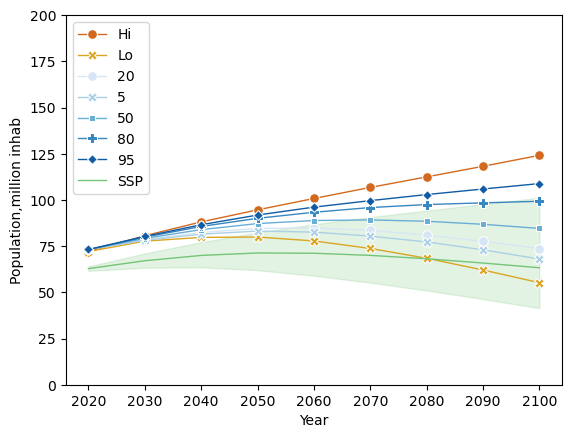

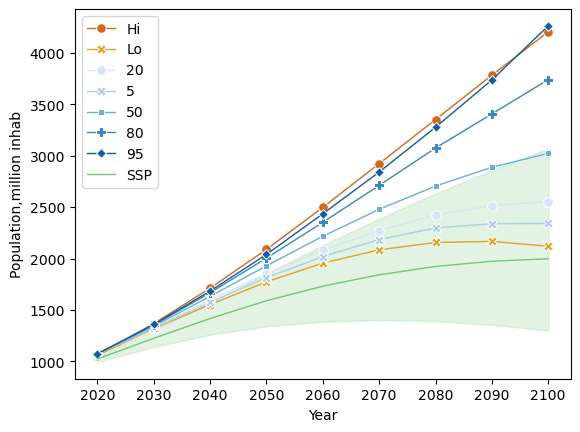

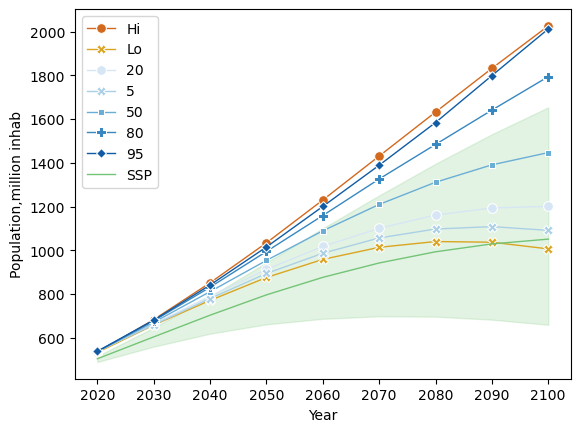

In [10]:
plotdata = pd.concat( (pd.concat((regext, regprob)), allssp) )

plotdata = plotdata.replace({"Low variant": "Lo"})
plotdata = plotdata.replace({"High variant": "Hi"})
plotdata["Series"] = plotdata["Scenario"]

for r, rex in enumerate(shortnames):
    fig = plt.figure(r)
    data = pd.DataFrame( plotdata.loc[plotdata.Variant == "Deterministic"] )
    g = sns.lineplot(data=pd.DataFrame(data.loc[data.Region == rex]), 
    x="Year", y="Population", hue="Series", style="Series", estimator="median",  errorbar=('pi', 100),
    markers=True, linewidth=1,markersize=7, dashes=False, fillstyle="full",
    palette=["chocolate", "goldenrod"])

    data = pd.DataFrame( plotdata.loc[plotdata.Variant == "Probabilistic"] )
    g = sns.lineplot(data=pd.DataFrame(data.loc[data.Region == rex]), 
    x="Year", y="Population", hue="Series", style="Series", estimator="median",  errorbar=('pi', 100),
    markers=True, linewidth=1,markersize=7, dashes=False, fillstyle="full",
    palette="Blues")

    data = pd.DataFrame(plotdata.loc[plotdata.Variant == "SSP"] )
    g = sns.lineplot(data=pd.DataFrame(data.loc[data.Region == rex]), 
    x="Year", y="Population",hue="Variant", estimator="median",  errorbar=('pi', 100),
    markers=True, linewidth=1,markersize=7, dashes=False, fillstyle="full",
    palette="Greens")

#    g.set_ylim(6, 16)
    plt.xlabel("Year")
    plt.ylabel("Population,million inhab")
    plt.legend(loc='upper left')
    if r==0:
        g.set_ylim(0,200)
    fig.savefig(os.path.join(path_for_figure, "Regional_ssp" + shortnames[r] + ".png"), dpi=300)



## New SSPs

In [12]:
selected_scenarios = ["SSP1", "SSP2", "SSP3", "SSP4", "SSP5"]
allsspnew = pd.DataFrame()
for j, jj in enumerate(dict_list):
    n = len([rex for rex in jj.values()][0])
    region_dict = {k : v for k,v in zip([rex for rex in jj.values()][0], [shortnames[j] for i in range(n)] ) }
    data = readSSPnew(years, selected_scenarios, region_dict)
    data["Variant"] = "SSP"
    transdata = transformSSP(data, shortnames[j], years, "Population")
    transdata["Region"] = shortnames[j]
    transdata["Model"] = "IIASA-WiC POP 2023"
    transdata["Variant"] = "SSP"
    allsspnew = pd.concat((allsspnew,transdata))


blur
blur
blur


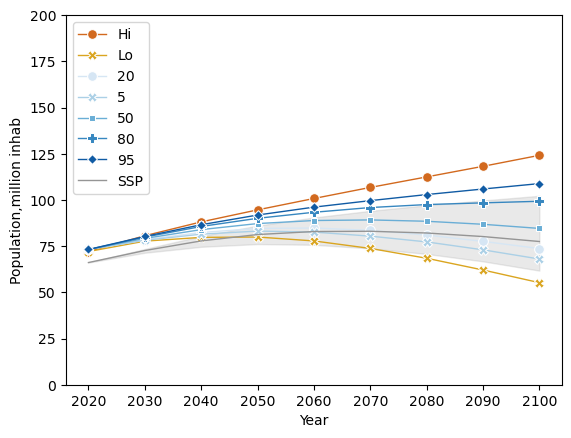

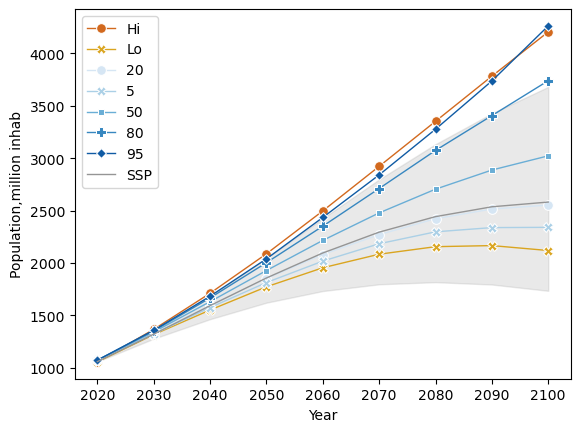

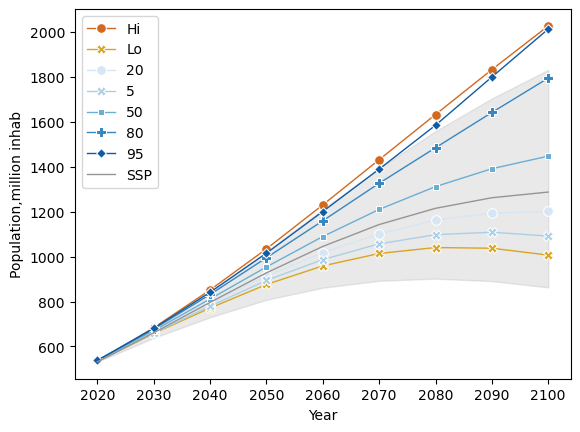

In [13]:
plotdata = pd.concat( (pd.concat((regext, regprob)), allsspnew) )

plotdata = plotdata.replace({"Low variant": "Lo"})
plotdata = plotdata.replace({"High variant": "Hi"})
plotdata["Series"] = plotdata["Scenario"]

for r, rex in enumerate(shortnames):
    fig = plt.figure(r)
    data = pd.DataFrame( plotdata.loc[plotdata.Variant == "Deterministic"] )
    g = sns.lineplot(data=pd.DataFrame(data.loc[data.Region == rex]), 
    x="Year", y="Population", hue="Series", style="Series", estimator="median",  errorbar=('pi', 100),
    markers=True, linewidth=1,markersize=7, dashes=False, fillstyle="full",
    palette=["chocolate", "goldenrod"])

    data = pd.DataFrame( plotdata.loc[plotdata.Variant == "Probabilistic"] )
    g = sns.lineplot(data=pd.DataFrame(data.loc[data.Region == rex]), 
    x="Year", y="Population", hue="Series", style="Series", estimator="median",  errorbar=('pi', 100),
    markers=True, linewidth=1,markersize=7, dashes=False, fillstyle="full",
    palette="Blues")

    data = pd.DataFrame(plotdata.loc[plotdata.Variant == "SSP"] )
    g = sns.lineplot(data=pd.DataFrame(data.loc[data.Region == rex]), 
    x="Year", y="Population",hue="Variant", estimator="median",  errorbar=('pi', 100),
    markers=True, linewidth=1,markersize=7, dashes=False, fillstyle="full",
    palette="Greys")

#    g.set_ylim(6, 16)
    plt.xlabel("Year")
    plt.ylabel("Population,million inhab")
    plt.legend(loc='upper left')
    if r==0:
        g.set_ylim(0,200)
    fig.savefig(os.path.join(path_for_figure, "Regional_sspnew" + shortnames[r] + ".png"), dpi=300)



## Part 3: Alternative lines of evidence


#### Data upload: alternative datasets (U.S. Census (IDB), World Bank, RFF, UN, SSPs, IHME)

In [15]:
# methods: U.S. Census (IDB)
region="WORLD"
censusg=ext_census(years)

# methods: World Bank
columns = censusg.columns
wbyears = [2020, 2030, 2040, 2050]
wbankg = ext_wbank(columns, wbyears)

# methods: RFF
pdRFF = ext_RFF(years)

# methods: UN
remove_scenarios = ['Constant-fertility', 'Instant-replacement', 'Instant-replacement zero migr', 'No change']
undata2022, undata2022_ext= ext_undata(w2022_1, w2022_1ext, pdRFF.columns, remove_scenarios)
undata2019, undata2019_ext= ext_undata(w2019_1, w2019_1ext, pdRFF.columns, remove_scenarios)
undata2015, undata2015_ext= ext_undata(w2015_1, w2015_1ext, pdRFF.columns, remove_scenarios)

# methods: SSPs
SSPgroups = readSSP(years)[2]
pdRFFchart = pdRFF.drop(["Series"], axis=1)

transSSP = transformSSP(SSPgroups,"WORLD", years, "Population")
transSSP["Model"] ="SSP"
transSSP = transSSP.rename(columns={"sYear": "Year"})
transSSP["Population"] *= 1/1000
SSPRFF = pd.concat((transSSP, pdRFFchart))
SSPRFF["Year"] = pd.Series(SSPRFF["Year"], dtype=int)

# methods: new SSPs
selected_scenarios = ['SSP1', 'SSP2', 'SSP3', 'SSP4', 'SSP5']
region_dict = {
                "World": "WORLD",
                "Asia (R5)": "R5ASIA",
                "Latin America (R5)": "R5LAM",
                "Middle East & Africa (R5)": "R5MAF",
                "OECD & EU (R5)": "R5OECD90+EU",
                "Reforming Economies (R5)": "R5REF"}
SSPvnew = readSSPnew(years, selected_scenarios, region_dict)
SSPvnew_transp=transformSSP(SSPvnew, "WORLD", years, "Population")
SSPvnew_transp["Population"] *= 1/1000
SSPUN= pd.concat((pd.concat((transSSP,undata2022)), undata2022_ext))
SSPUN = pd.concat((SSPUN,SSPvnew_transp))
SSPUN["Year"] = pd.Series(SSPUN["Year"], dtype=int)

# methods: IHME
ihmeframe=ext_ihme(columns, years)


blur
blur


#### Estimate of population peaks across databases (U.S. Census (IDB), World Bank, RFF, UN, SSPs, IHME)

In [10]:
maxestimate(SSPUN, undata2022, censusg, wbankg, ihmeframe)

IDB  has maximum of  10.617  billion inhabitants in year  2100
World Bank  has maximum of  9.712  billion inhabitants in year  2050
SSP1  has maximum of  8.463  billion inhabitants in year  2050
SSP2  has maximum of  9.458  billion inhabitants in year  2070
SSP3  has maximum of  12.697  billion inhabitants in year  2100
SSP4  has maximum of  9.507  billion inhabitants in year  2080
SSP5  has maximum of  8.579  billion inhabitants in year  2060
pUN 95 perc  has maximum of  12.412  billion inhabitants in year  2100
pUN 50 perc  has maximum of  10.424  billion inhabitants in year  2090
pUN 25 perc  has maximum of  9.829  billion inhabitants in year  2070
pUN 5 perc  has maximum of  9.576  billion inhabitants in year  2070
UN low variant  has maximum of  8.928  billion inhabitants in year  2050
UN high variance  has maximum of  14.807  billion inhabitants in year  2100
Scenario  Faster  has maximum of  9.291  billion inhabitants in year  2060
Scenario  Fastest  has maximum of  8.983  billi

### Figure 1 (a, b, c ,d)

#### Data plotting: alternative datasets (U.S. Census (IDB), World Bank, RFF, UN, SSPs, IHME)

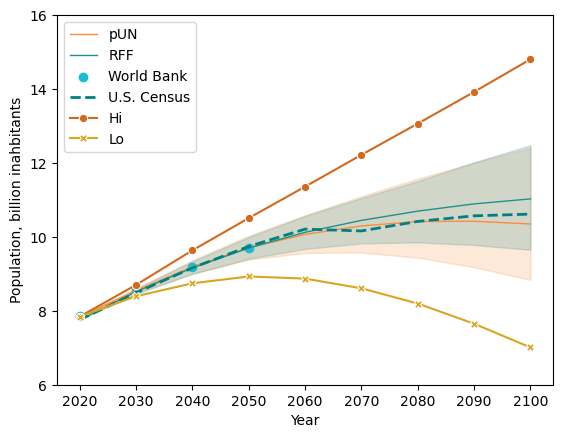

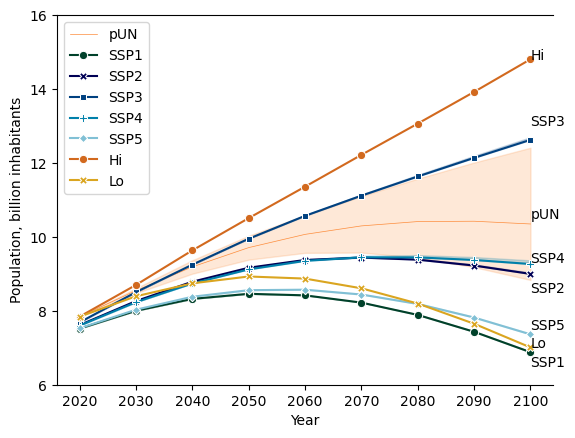

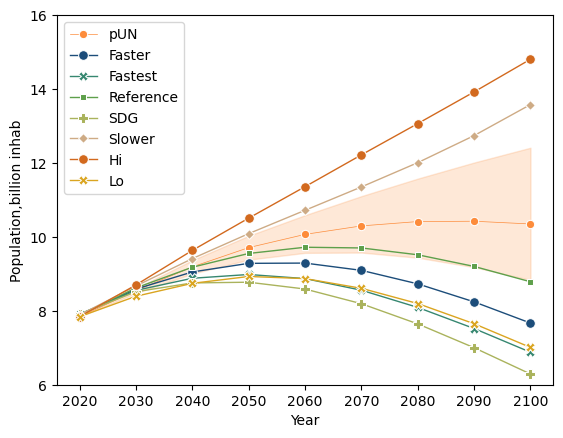

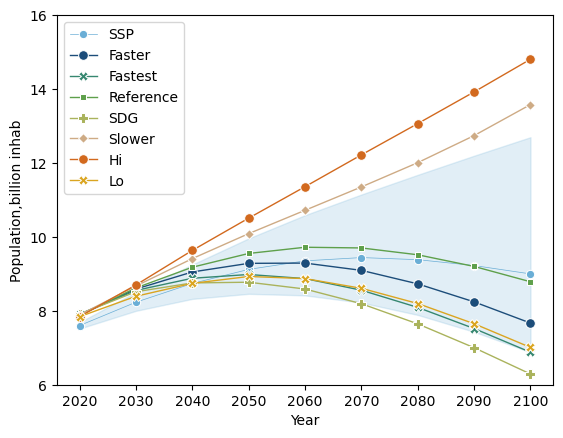

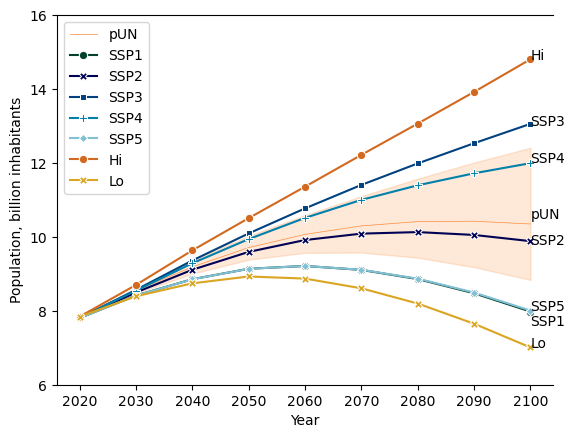

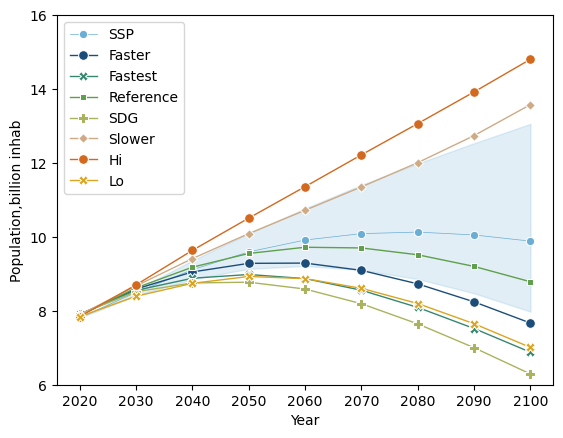

In [16]:
fig=plt.figure(1)
censusg["Series"] = censusg["Model"]
undata2022_ext["Series"] = undata2022_ext["Scenario"]
undata2022_ext["IPCCRegion"] = "WORLD"
wbankg["Series"] = wbankg["Model"]

data = pd.concat((pd.concat((pd.concat((undata2022, censusg)), wbankg)), undata2022_ext[[col for col in undata2022_ext.columns if col!= "Scenario"]]))
data["IPCCRegion"] = "WORLD"

regions = ["WORLD"]

for r,region in enumerate(regions):

    datar = data.loc[data.IPCCRegion == region]

    g = sns.lineplot(data=pd.DataFrame(datar.loc[datar.Model == "pUN" ]), 
    x="Year", y="Population", hue="Model", estimator="median", errorbar=('pi', 100),
    markers=True, linewidth=1, markersize=7, dashes=False, fillstyle="full",
    palette="Oranges")

    sns.lineplot(data=pdRFF, x=pdRFF.Year, y= pdRFF.Population, hue="Model", 
    estimator="median",  errorbar=("pi",100), palette="viridis",
    markers=True, linewidth=1, markersize=7, dashes=False, fillstyle="full")

    wadd = pd.DataFrame(datar.loc[datar.Model == "World Bank"]).rename(columns={"Population": "World Bank"})
    g.x = wadd.Year
    g.y = wadd["World Bank"]
    g.scatter(data=wadd, x="Year", y="World Bank", c='#17becf', linewidths=1)

    wadd = pd.DataFrame(datar.loc[datar.Model == "U.S. Census"]).rename(columns={"Population": "U.S. Census"})
    g.x = wadd.Year
    g.y = wadd["U.S. Census"]
    plt.plot(g.x, g.y, label= "U.S. Census", c="teal", linestyle='dashed', linewidth=2, markersize=20)

    data=SSPUN.loc[SSPUN.Model=="dUN"]
    data = data.replace({"Low variant": "Lo"})
    data = data.replace({"High variant": "Hi"})
    g=sns.lineplot(data=data, x=data.Year, y= data.Population,  hue="Scenario",  style="Scenario" , 
    estimator="median", errorbar=("pi", 100), markers=True, dashes=False, palette=["chocolate", "goldenrod"])

    plt.legend(loc="upper left")

    plt.ylabel("Population, billion inahbitants")
    g.set_ylim(6,16)

fig.savefig(os.path.join(path_for_figure, "world_databases.png"), dpi=300)


fig=plt.figure(2)
data=SSPUN.loc[SSPUN.Model=="pUN"]
labels = []
labels.append("pUN")
g=sns.lineplot(data=data, x=data.Year, y= data.Population, hue="Model",  style="Model" , 
estimator="median", errorbar=("pi", 100), markers=False, dashes=True, palette="Oranges", linewidth=0.5)
plt.text(2100, 10.5, labels[0])

data=SSPUN.loc[SSPUN.Model=="SSP"]
g=sns.lineplot(data=data, x=data.Year, y= data.Population, hue="Scenario",  style="Scenario" , 
estimator="median", errorbar=("pi", 100), markers=True, dashes=False, palette ="ocean")
labels = []
labels.append("SSP1")
labels.append("SSP2")
labels.append("SSP3")
labels.append("SSP4")
labels.append("SSP5")

plt.text(2100, 6.5, labels[0])
plt.text(2100, 8.5, labels[1])
plt.text(2100, 13, labels[2])
plt.text(2100, 9.3, labels[3])
plt.text(2100, 7.5, labels[4])


data=SSPUN.loc[SSPUN.Model=="dUN"]
data = data.replace({"Low variant": "Lo"})
data = data.replace({"High variant": "Hi"})
g=sns.lineplot(data=data, x=data.Year, y= data.Population,  hue="Scenario",  style="Scenario" , 
estimator="median", errorbar=("pi", 100), markers=True, dashes=False, palette=["chocolate", "goldenrod"])
labels = []
labels.append("Lo")
labels.append("Hi")

plt.text(2100, 7, labels[0])
plt.text(2100, 14.8, labels[1])
plt.legend(loc="upper left")

plt.ylabel("Population, billion inhabitants")
plt.xlabel("Year")
g.set_ylim(6, 16)
g.spines['right'].set_visible(False)

fig.savefig(os.path.join(path_for_figure, "SSP_UN_chart_global.png"), dpi=300)

fig=plt.figure(3)
data=SSPUN.loc[SSPUN.Model=="pUN"]

g = sns.lineplot(data=data, x=data.Year, y= data.Population, hue="Model",  style="Model" , 
estimator="median", errorbar=("pi", 100), markers=True, palette="Oranges", linewidth=0.5)

data = ihmeframe.copy(deep=True)
data = data.replace({"Faster Met Need and Education": "Faster", 
                     "Fastest Met Need and Education": "Fastest",
                     "Reference": "Reference",
                     "SDG Met Need and Education": "SDG",
                     "Slower Met Need and Education": "Slower"})

ax = sns.lineplot(data=pd.DataFrame(data.loc[data.Model == "IHME" ]), 
x="Year", y="Population", hue="Series", style="Series", estimator="median",  errorbar=('pi', 100),
markers=True, linewidth=1,markersize=7, dashes=False, fillstyle="full",
palette="gist_earth")


data=pd.DataFrame(SSPUN.loc[SSPUN.Model=="dUN"])
data = data.replace({"Low variant": "Lo"})
data = data.replace({"High variant": "Hi"})
data["Series"] = data["Scenario"]
ax2 = sns.lineplot(data=pd.DataFrame(data.loc[data.Model == "dUN" ]), 
x="Year", y="Population", hue="Series", style="Series", estimator="median",  errorbar=('pi', 100),
markers=True, linewidth=1, markersize=7, dashes=False, fillstyle="full",
palette=["chocolate", "goldenrod"])

g.set_ylim(6, 16)
plt.xlabel("Year")
plt.ylabel("Population,billion inhab")
plt.legend(loc='upper left')
fig.savefig(os.path.join(path_for_figure, "pUN_IHME_chart_global.png"), dpi=300)


fig=plt.figure(4)

data=SSPUN.loc[SSPUN.Model=="SSP"]

g = sns.lineplot(data=data, x=data.Year, y= data.Population, hue="Model",  style="Model" , 
estimator="median", errorbar=("pi", 100), markers=True, palette="Blues", linewidth=0.5)


data = ihmeframe.copy(deep=True)
data = data.replace({"Faster Met Need and Education": "Faster", 
                     "Fastest Met Need and Education": "Fastest",
                     "Reference": "Reference",
                     "SDG Met Need and Education": "SDG",
                     "Slower Met Need and Education": "Slower"})

g= sns.lineplot(data=pd.DataFrame(data.loc[data.Model == "IHME" ]), 
x="Year", y="Population", hue="Series", style="Series", estimator="median",  errorbar=('pi', 100),
markers=True, linewidth=1,markersize=7, dashes=False, fillstyle="full",
palette="gist_earth")


data=pd.DataFrame(SSPUN.loc[SSPUN.Model=="dUN"])
data = data.replace({"Low variant": "Lo"})
data = data.replace({"High variant": "Hi"})
data["Series"] = data["Scenario"]
g = sns.lineplot(data=pd.DataFrame(data.loc[data.Model == "dUN" ]), 
x="Year", y="Population", hue="Series", style="Series", estimator="median",  errorbar=('pi', 100),
markers=True, linewidth=1,markersize=7, dashes=False, fillstyle="full",
palette=["chocolate", "goldenrod"])

g.set_ylim(6, 16)
plt.xlabel("Year")
plt.ylabel("Population,billion inhab")
plt.legend(loc='upper left')
fig.savefig(os.path.join(path_for_figure, "SSP_IHME_chart_global.png"), dpi=300)



fig=plt.figure(5)
data=SSPUN.loc[SSPUN.Model=="pUN"]
labels = []
labels.append("pUN")
g=sns.lineplot(data=data, x=data.Year, y= data.Population, hue="Model",  style="Model" , 
estimator="median", errorbar=("pi", 100), markers=False, dashes=True, palette="Oranges", linewidth=0.5)
plt.text(2100, 10.5, labels[0])

data=pd.DataFrame(SSPUN.loc[SSPUN.Model=="IIASA-WiC POP 2023"])
data["Model"] = "SSP"
g=sns.lineplot(data=data, x=data.Year, y= data.Population, hue="Scenario",  style="Scenario" , 
estimator="median", errorbar=("pi", 100), markers=True, dashes=False, palette ="ocean")
labels = []
labels.append("SSP1")
labels.append("SSP2")
labels.append("SSP3")
labels.append("SSP4")
labels.append("SSP5")

plt.text(2100, 7.6, labels[0])
plt.text(2100, 9.8, labels[1])
plt.text(2100, 13, labels[2])
plt.text(2100, 12, labels[3])
plt.text(2100, 8, labels[4])


data=SSPUN.loc[SSPUN.Model=="dUN"]
data = data.replace({"Low variant": "Lo"})
data = data.replace({"High variant": "Hi"})
g=sns.lineplot(data=data, x=data.Year, y= data.Population,  hue="Scenario",  style="Scenario" , 
estimator="median", errorbar=("pi", 100), markers=True, dashes=False, palette=["chocolate", "goldenrod"])
labels = []
labels.append("Lo")
labels.append("Hi")

plt.text(2100, 7, labels[0])
plt.text(2100, 14.8, labels[1])
plt.legend(loc="upper left")

plt.ylabel("Population, billion inhabitants")
plt.xlabel("Year")
g.set_ylim(6, 16)
g.spines['right'].set_visible(False)

fig.savefig(os.path.join(path_for_figure, "SSPnew_UN_chart_global.png"), dpi=300)


fig=plt.figure(6)
# Represents the comparison between population models and new SSPs
data=pd.DataFrame(SSPUN.loc[SSPUN.Model=="IIASA-WiC POP 2023"])
data["Model"] = "SSP"

g = sns.lineplot(data=data, x=data.Year, y= data.Population, hue="Model",  style="Model" , 
estimator="median", errorbar=("pi", 100), markers=True, palette="Blues", linewidth=0.5)


data = ihmeframe.copy(deep=True)
data = data.replace({"Faster Met Need and Education": "Faster", 
                     "Fastest Met Need and Education": "Fastest",
                     "Reference": "Reference",
                     "SDG Met Need and Education": "SDG",
                     "Slower Met Need and Education": "Slower"})

g= sns.lineplot(data=pd.DataFrame(data.loc[data.Model == "IHME" ]), 
x="Year", y="Population", hue="Series", style="Series", estimator="median",  errorbar=('pi', 100),
markers=True, linewidth=1,markersize=7, dashes=False, fillstyle="full",
palette="gist_earth")


data=pd.DataFrame(SSPUN.loc[SSPUN.Model=="dUN"])
data = data.replace({"Low variant": "Lo"})
data = data.replace({"High variant": "Hi"})
data["Series"] = data["Scenario"]
g = sns.lineplot(data=pd.DataFrame(data.loc[data.Model == "dUN" ]), 
x="Year", y="Population", hue="Series", style="Series", estimator="median",  errorbar=('pi', 100),
markers=True, linewidth=1,markersize=7, dashes=False, fillstyle="full",
palette=["chocolate", "goldenrod"])

g.set_ylim(6, 16)
plt.xlabel("Year")
plt.ylabel("Population,billion inhab")
plt.legend(loc='upper left')
fig.savefig(os.path.join(path_for_figure, "SSPnew_IHME_chart_global.png"), dpi=300)


### Figure 2 without UN deterministic projections (Hi and Lo)

Text(2105, 7.4, 'SSP5')

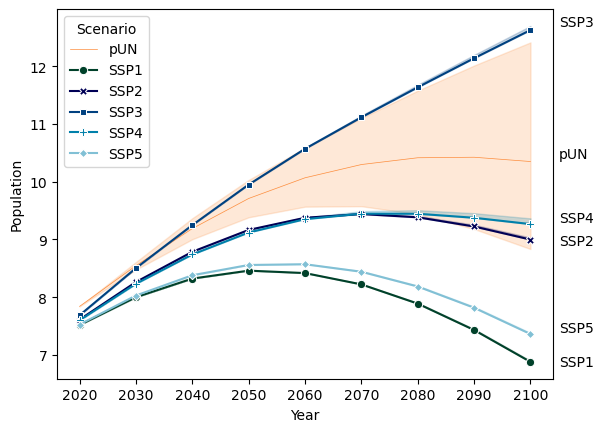

In [17]:
plt.figure(7)
data=SSPUN.loc[SSPUN.Model=="pUN"]
labels = []
labels.append("pUN")
g=sns.lineplot(data=data, x=data.Year, y= data.Population, hue="Model",  style="Model" , 
estimator="median", errorbar=("pi", 100), markers=False, dashes=True, palette="Oranges", linewidth=0.5)
plt.text(2105, 10.4, labels[0])

data=SSPUN.loc[SSPUN.Model=="SSP"]
g=sns.lineplot(data=data, x=data.Year, y= data.Population, hue="Scenario",  style="Scenario" , 
estimator="median", errorbar=("pi", 100), markers=True, dashes=False, palette ="ocean")
labels = []
labels.append("SSP1")
labels.append("SSP2")
labels.append("SSP3")
labels.append("SSP4")
labels.append("SSP5")

plt.text(2105, 6.8, labels[0])
plt.text(2105, 8.9, labels[1])
plt.text(2105, 12.7, labels[2])
plt.text(2105, 9.3, labels[3])
plt.text(2105, 7.4, labels[4])

### Figure 2 (a, b)

Panel a: historical years for different databases

blur


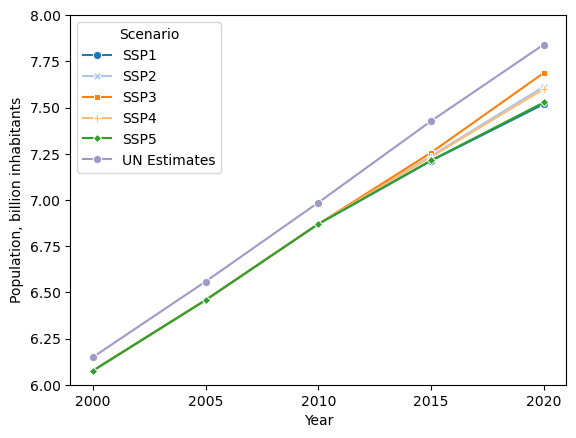

In [18]:
SSPgroups1 = readSSP(hist_years)[2]

SSPgroups1["2000"]= SSPgroups1["2000"].replace(0, np.nan).bfill()
SSPgroups1["2005"]= SSPgroups1["2005"].replace(0, np.nan).bfill()
SSPgroups1["2015"]= SSPgroups1["2015"].replace(0, np.nan).bfill()

transSSP1 = transformSSP(SSPgroups1,"WORLD", hist_years, "Population")
transSSP1["Model"] ="SSP"
transSSP1 = transSSP1.rename(columns={"sYear": "Year"})
transSSP1["Population"] *= 1/1000
transSSP1 = transSSP1.groupby(["Year", "Scenario", "Model"]).mean().reset_index()
transSSP1["Year"] = pd.Series(transSSP1["Year"], dtype=int)


ax=sns.lineplot(data=transSSP1, x=transSSP1.Year, y= transSSP1.Population, hue="Scenario",  style="Scenario" , 
estimator="median", errorbar=("pi", 100), markers=True, dashes=False, palette ="tab20")
ax.set_xticks(hist_years)


undata2022_hist = transformUN(w2022_1hist, "WORLD", False)
undata2022_hist["Model"] = "dUN"
undata2022_hist["Population"] *= 1/1000
undata2022_hist = undata2022_hist.replace({"Estimates": "UN Estimates"})
ax=sns.lineplot(data=undata2022_hist, x=undata2022_hist.Year, y= undata2022_hist.Population, hue="Scenario",  style="Scenario" , 
estimator="median", errorbar=("pi", 100), markers=True, dashes=False, palette ="Purples")
ax.set_xticks(hist_years)

plt.ylabel("Population, billion inhabitants")
plt.ylim(6, 8)
fig.savefig(os.path.join(path_for_figure, "SSP_UN_historical.png"), dpi=300)

Panel b: historical revision of UN

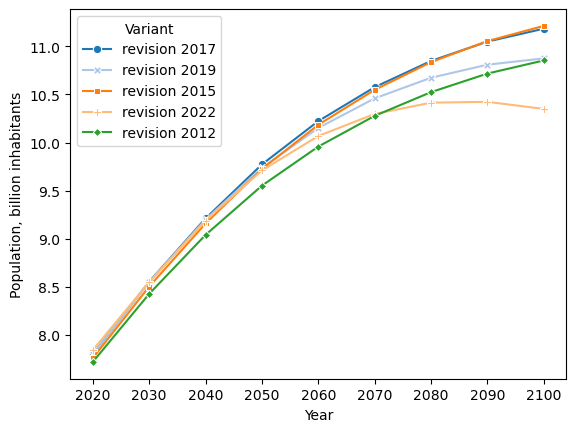

In [19]:
all_det = pd.DataFrame()
for vars in set(wversion.Variant):
    data = transformUN(pd.DataFrame(wversion.loc[wversion.Variant==vars]),"WORLD", False)
    if vars != "revision_2010":
        data["Variant"] = vars
        all_det = pd.concat((all_det,data))
all_det["Population"] *= 1/1000
oldname = ["revision_2012", "revision_2015", "revision_2017", "revision_2019", "revision_2022"]
newname = ["revision 2012", "revision 2015", "revision 2017", "revision 2019", "revision 2022"]
rename = dict(zip(oldname,newname))

all_det_chart = pd.DataFrame(all_det.loc[all_det.Scenario=="Medium variant"])
for name in oldname:
    all_det_chart = all_det_chart.replace(name, rename[name])
fig = plt.figure(9)
ax=sns.lineplot(data=all_det_chart, x=all_det_chart.Year, y= all_det_chart.Population, hue="Variant",  style="Variant" , 
estimator="median", errorbar=("pi", 100), markers=True, dashes=False, palette ="tab20")
ax.set_xticks(years)
plt.ylabel("Population, billion inhabitants")
fig.savefig(os.path.join(path_for_figure, "UN_projections.png"), dpi=300)

How new SSPs compare with historical trends

blur


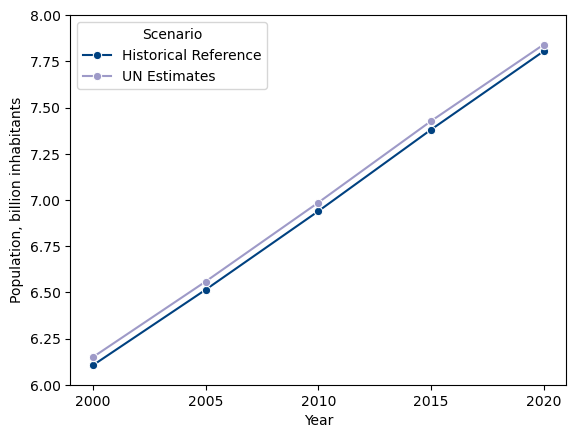

In [21]:
selected_scenarios = ["Historical Reference"]

region_dict = {
                "World": "WORLD",
                "Asia (R5)": "R5ASIA",
                "Latin America (R5)": "R5LAM",
                "Middle East & Africa (R5)": "R5MAF",
                "OECD & EU (R5)": "R5OECD90+EU",
                "Reforming Economies (R5)": "R5REF"}
SSPgroups1 = readSSPnew(hist_years, selected_scenarios, region_dict)

SSPgroups1["2000"]= SSPgroups1["2000"].replace(0, np.nan).bfill()
SSPgroups1["2005"]= SSPgroups1["2005"].replace(0, np.nan).bfill()
SSPgroups1["2015"]= SSPgroups1["2015"].replace(0, np.nan).bfill()

transSSP1 = transformSSP(SSPgroups1,"WORLD", hist_years, "Population")
transSSP1["Model"] ="SSP"
transSSP1 = transSSP1.rename(columns={"sYear": "Year"})
transSSP1["Population"] *= 1/1000
transSSP1 = transSSP1.groupby(["Year", "Scenario", "Model"]).mean().reset_index()
transSSP1["Year"] = pd.Series(transSSP1["Year"], dtype=int)


ax=sns.lineplot(data=transSSP1, x=transSSP1.Year, y= transSSP1.Population, hue="Scenario",  style="Scenario" , 
estimator="median", errorbar=("pi", 100), markers=True, dashes=False, palette ="ocean")
ax.set_xticks(hist_years)


undata2022_hist = transformUN(w2022_1hist, "WORLD", False)
undata2022_hist["Model"] = "dUN"
undata2022_hist["Population"] *= 1/1000
undata2022_hist = undata2022_hist.replace({"Estimates": "UN Estimates"})
ax=sns.lineplot(data=undata2022_hist, x=undata2022_hist.Year, y= undata2022_hist.Population, hue="Scenario",  style="Scenario" , 
estimator="median", errorbar=("pi", 100), markers=True, dashes=False, palette ="Purples")
ax.set_xticks(hist_years)

plt.ylabel("Population, billion inhabitants")
plt.ylim(6, 8)
fig.savefig(os.path.join(path_for_figure, "SSPnew_UN_historical.png"), dpi=300)

### Figure 8 (methods): comparison of deterministic and probabilistic projections of UN 2022 revision

Panel a: deterministic projections of UN
Panel b: deterministic and probabilistic projections of UN

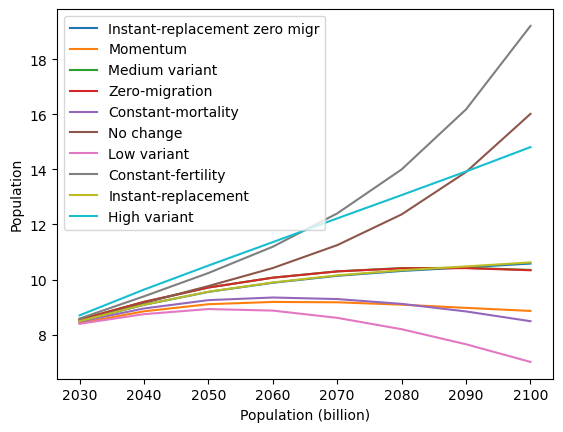

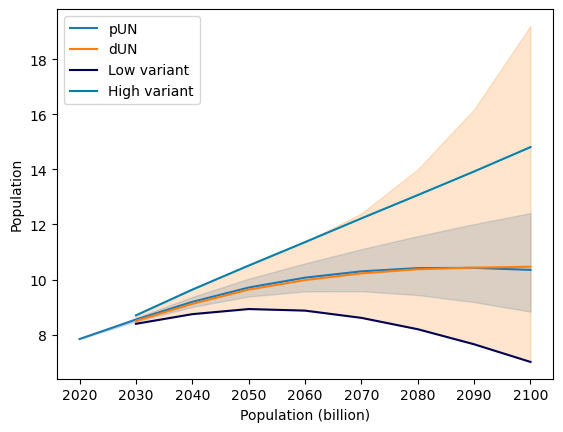

In [22]:
plt.figure(1)
wversion2022 = pd.DataFrame(wversion.loc[wversion.Variant == "revision_2022"]).drop(["UNRegion", "Variant"], axis=1)

scenarios = list(set(wversion2022.Scenario))
allwscenario = pd.DataFrame()
for s in scenarios:
    wverscenario=transformUN(wversion2022.loc[wversion2022.Scenario==s], "WORLD", "False")
    allwscenario = pd.concat((allwscenario, wverscenario))
allwscenario["Population"] *= 1/1000
ax=sns.lineplot(allwscenario, x=allwscenario.Year, y=allwscenario.Population, hue=allwscenario.Scenario)
label = "Population (billion)"
ax.set_xlabel(label)
ax.legend(loc='upper left')
fignane = os.path.join(path_for_figure, "dUN_projections.png")
fig.savefig(fignane, dpi=300)


plt.figure(2)
allwscenario["Model"] = "dUN"
selscenario = pd.concat(( undata2022, allwscenario))
ax = sns.lineplot(selscenario, x=selscenario.Year, y=selscenario.Population,
            hue="Model", estimator="median", errorbar=('pi', 100))
low = pd.DataFrame(allwscenario.loc[allwscenario.Scenario == "Low variant"])
high = pd.DataFrame(allwscenario.loc[allwscenario.Scenario == "High variant"])
lhscenario = pd.concat((low,high))

ax = sns.lineplot(lhscenario, x=lhscenario.Year, y=lhscenario.Population,
            hue="Scenario", estimator="median", errorbar=('pi', 100), palette ="ocean")
label = "Population (billion)"
ax.set_xlabel(label)
ax.legend(loc='upper left')
fignane = os.path.join(path_for_figure, "dUN_pUN_global.png")
fig.savefig(fignane, dpi=300)


## Part 4: Statistical analysis of assessment reports at a global level

AR5, SR 1.5, and AR6 data selection

In [24]:
dataset = "AR5"
years = [2020, 2030, 2040, 2050, 2060, 2070, 2080, 2090, 2100 ]
quantiles = (0.005, 0.995)
ar5HIt = transformAR(ar5HI, "WORLD", dataset, quantiles, years, "Population", "Population")
# ARs contain population data in million inhab.
# population converted to billion
ar5HIt["Population"] *= 1/1000

dataset = "SR 1.5"
ar15HIt = transformAR(ar15HI, "WORLD", dataset, quantiles, years, "Population", "Population")
# ARs contain population data in million inhab.
# population converted to billion
ar15HIt["Population"] *= 1/1000

dataset = "AR6"
ar6HIt = transformAR(ar6HI, "WORLD", dataset, quantiles, years, "Population", "Population")
# ARs contain population data in million inhab.
# population converted to billion
ar6HIt["Population"] *= 1/1000

arsdata = pd.concat((pd.concat((ar5HIt, ar15HIt)), ar6HIt))

### Figure 3 (a, b, c, d)

Figure 3 represents the distribution of the world population in billion inhab as obtained from AR5, SR 1.5, and AR6

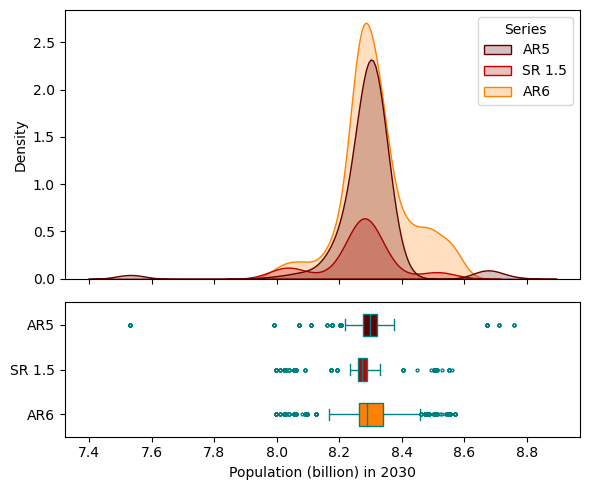

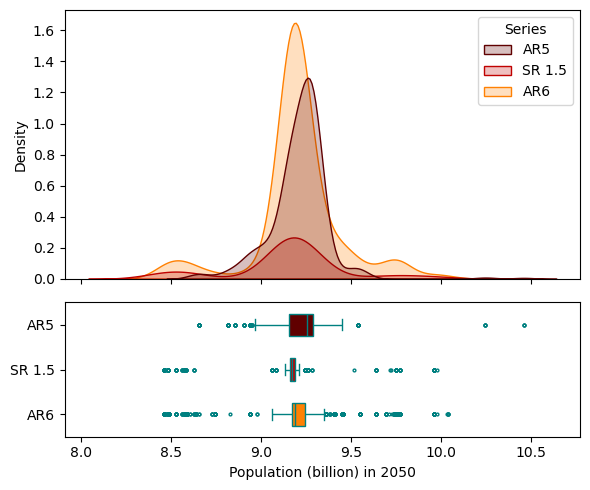

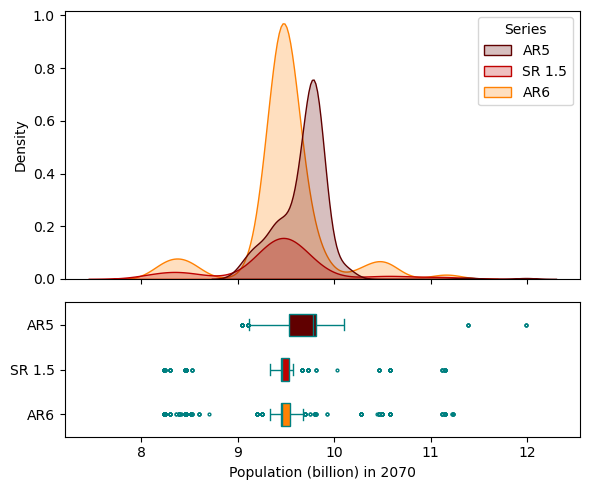

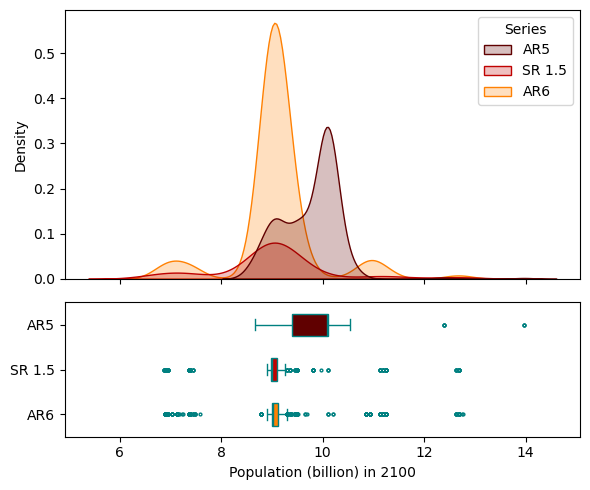

In [25]:
data=arsdata.copy(deep=True)
sel_years = [2030, 2050, 2070, 2100]

for year in sel_years:
    fig, (ax1,ax2) = plt.subplots(2,1, sharex=True, figsize=(6,5), height_ratios=[1, 0.5])
    fig.set_tight_layout(True)
    g1= sns.kdeplot(data[data.Year==year], x="Population", hue="Series",fill=True,
    palette="gist_heat", common_norm=True, bw_method="scott", bw_adjust=1.5,  ax=ax1)

    g2= sns.boxplot(data[data.Year==year], x="Population", y="Series", hue="Series", 
    orient="h", palette="gist_heat", ax=ax2, linewidth=1, fliersize=2, width=0.5, gap=0.0,
    saturation=2, fill=True, linecolor="teal", whis=1.5, showfliers=True)
    label = "Population (billion) in " + str(year)
    ax2.set_xlabel(label)
    ax2.set_ylabel("")
    ax2.set_yticks([0, 1, 2])
    ax2.set_yticklabels(["AR5", "SR 1.5", "AR6"])
    fignane = os.path.join(path_for_figure, "pdf_databases"+str(year)+".png")
    fig.savefig(fignane, dpi=300)
    

### Figure 4 (a, b, c, d)

Density distributions of population deviations in 2030, 2050, 2070, and 2100 for the AR6 population eensemble from the one used in AR5 and SR 1.5

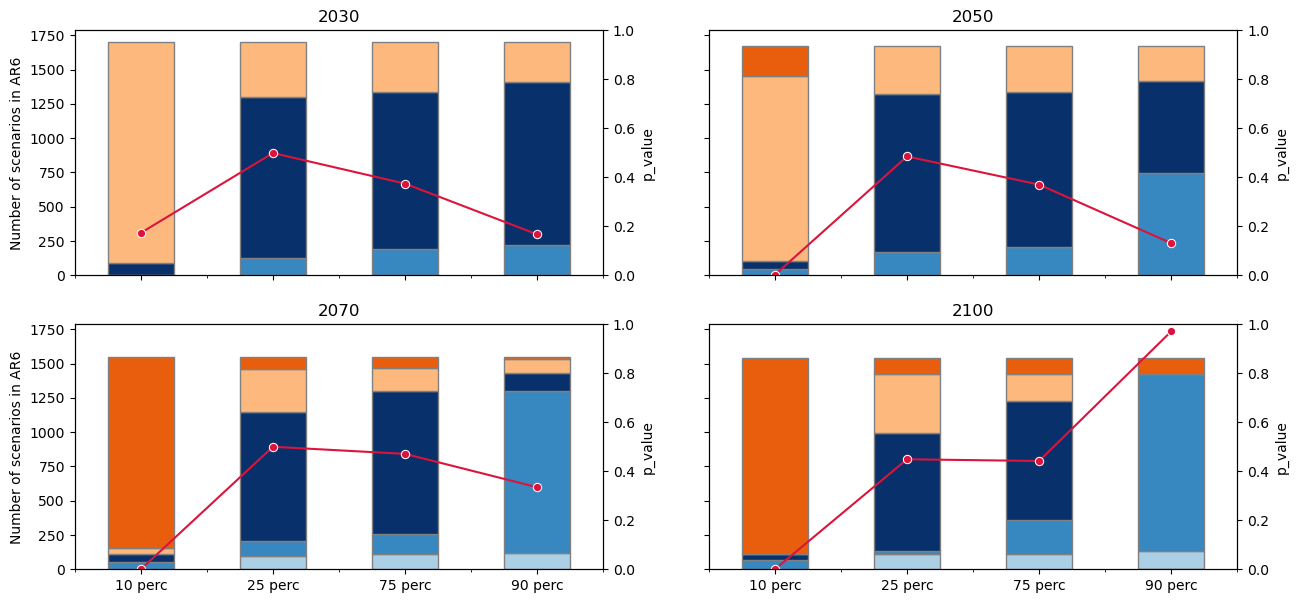

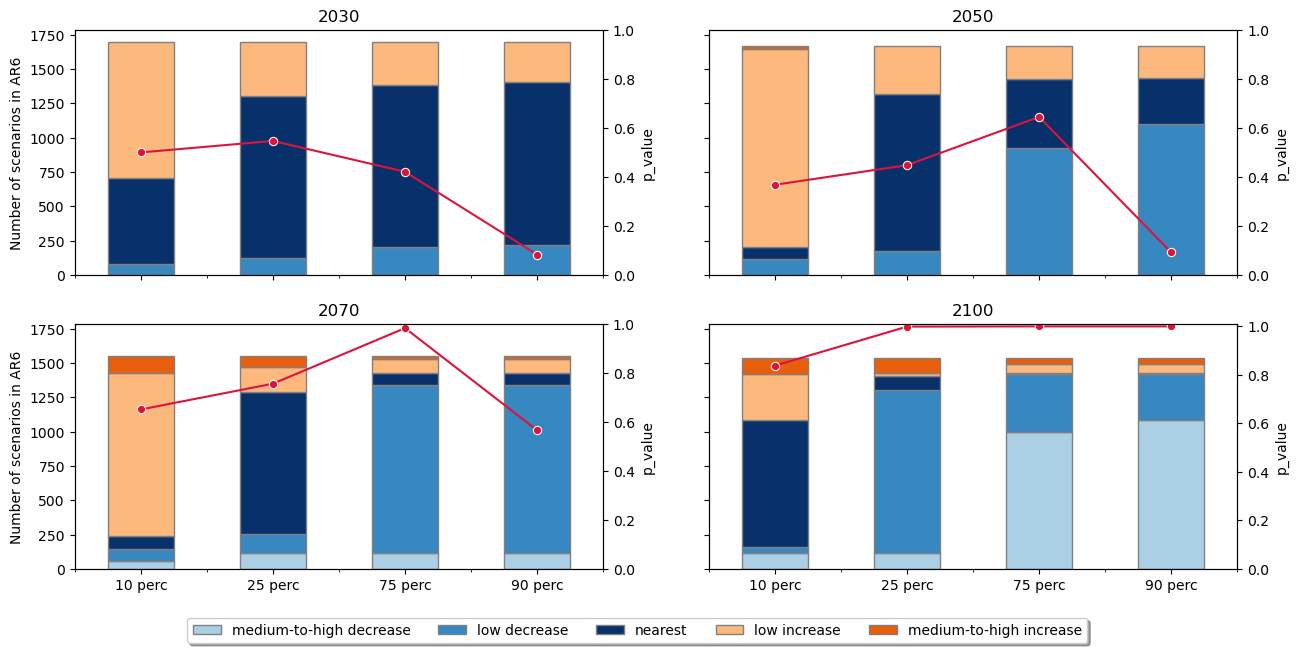

In [26]:
datablist2 = [ar15HIt, ar5HIt]
datablist1 = [ar6HIt, ar6HIt]
namelist2 = ["AR5", "SR 1.5"]
namelist1 = ["AR6", "AR6"]
figlabels = ["AR5", "SR1.5"]
cutuple1 = (0., 0.)
cutuple2 =[(0.0,0.0), (0.0, 0.0)]


for d in range(len(datablist2)):
    name2 = namelist2[d]
    name1 = namelist1[d]    
    database1 = datablist1[d]
    database2 = datablist2[d]
    data = pd.DataFrame()
    datap = databdiff(database1, name1, database2, name2, 
                     "Population", "percentile", 0.05,  "greater", 
                     cutuple1[0], cutuple1[1], cutuple2[d][0], cutuple2[d][1], sel_years)
    datap["Scenario"] = "5 perc"
    data = pd.concat((data, datap), axis=0)

    datap = databdiff(database1, name1, database2, name2, 
                     "Population", "percentile", 0.1,  "greater", 
                     cutuple1[0], cutuple1[1], cutuple2[d][0], cutuple2[d][1], sel_years)
    datap["Scenario"] = "10 perc"
    data = pd.concat((data, datap), axis=0)

    datap = databdiff(database1, name1, database2, name2, 
                     "Population", "percentile", 0.25,  "greater", 
                     cutuple1[0], cutuple1[1], cutuple2[d][0], cutuple2[d][1], sel_years)
    datap["Scenario"] = "25 perc"
    data = pd.concat((data, datap), axis=0)

    datap = databdiff(database1, name1, database2, name2, 
                     "Population", "percentile", 0.33,  "greater", 
                     cutuple1[0], cutuple1[1], cutuple2[d][0], cutuple2[d][1], sel_years)                    
    datap["Scenario"] = "33 perc"
    data = pd.concat((data, datap), axis=0)

    datap = databdiff(database1, name1, database2, name2, 
                     "Population", "mean", 0.00,  "greater", 
                     cutuple1[0], cutuple1[1], cutuple2[d][0], cutuple2[d][1], sel_years)                    
    datap["Scenario"] = "mean"
    data = pd.concat((data, datap), axis=0)

    datap = databdiff(database1, name1, database2, name2, 
                     "Population", "percentile", 0.50,  "greater", 
                     cutuple1[0], cutuple1[1], cutuple2[d][0], cutuple2[d][1], sel_years)                                       
    datap["Scenario"] = "50 perc"

    data = pd.concat((data, datap), axis=0)
    datap = databdiff(database1, name1, database2, name2, 
                     "Population", "std", 0.00,  "greater", 
                     cutuple1[0], cutuple1[1], cutuple2[d][0], cutuple2[d][1], sel_years)                   
    datap["Scenario"] = "std"
    data = pd.concat((data, datap), axis=0)

    datap = databdiff(database1, name1, database2, name2, 
                     "Population", "percentile", 0.66,  "greater", 
                     cutuple1[0], cutuple1[1], cutuple2[d][0], cutuple2[d][1], sel_years)                   
    datap["Scenario"] = "66 perc"
    data = pd.concat((data, datap), axis=0)

    datap = databdiff(database1, name1, database2, name2, 
                     "Population", "percentile", 0.75,  "greater", 
                     cutuple1[0], cutuple1[1], cutuple2[d][0], cutuple2[d][1], sel_years)                   
    datap["Scenario"] = "75 perc"
    data = pd.concat((data, datap), axis=0)

    datap = databdiff(database1, name1, database2, name2, 
                     "Population", "percentile", 0.90,  "greater", 
                     cutuple1[0], cutuple1[1], cutuple2[d][0], cutuple2[d][1], sel_years)                 
    datap["Scenario"] = "90 perc"
    data = pd.concat((data, datap), axis=0)

    datap = databdiff(database1, name1, database2, name2, 
                     "Population", "percentile", 0.95,  "greater", 
                     cutuple1[0], cutuple1[1], cutuple2[d][0], cutuple2[d][1], sel_years)                   
    datap["Scenario"] = "95 perc"
    data = pd.concat((data, datap), axis=0)
    
    sel_years = [2030, 2050, 2070, 2100]
    selyears = pd.DataFrame(data[data.year.isin(sel_years)])
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 7), sharex=True, sharey=True)
    axes = axes.ravel()  # array to 1D

    series = ["10 perc", "25 perc", "75 perc", "90 perc"]
    figseries = ["10", "25", "75", "90"]
    # Apply colormap


    cols = [col for col in data.columns if col not in ["year"]]
    cols = [col for col in cols if col not in ["p_value"]]
    cmap = colormaps.get_cmap('Blues')
    bar_colors_neg = cmap(np.linspace(0, 1, int(len(cols)/2) + 1))
    cmap = colormaps.get_cmap('Oranges') #cm.get_cmap('Oranges')
    bar_colors_pos = cmap(np.linspace(0, 1, int(len(cols)/2) + 1))
    bar_colors = np.vstack((bar_colors_neg[1:],bar_colors_pos[1:]))

    for year,ax1 in zip(sel_years,axes):
        seldata = pd.DataFrame(selyears[selyears.year == year])
        seldata = pd.DataFrame(seldata[seldata.Scenario.isin(series)])
        seldata[cols].plot(kind='bar', stacked=True, color=bar_colors, ax=ax1, edgecolor ='grey')
        ax1.set_title(str(year))

        ax1.set_ylabel("Number of scenarios in AR6")
        ax1.set_xlabel("")
        ax1.set_xticks(ticks = range(len(series)), rotation=0, labels=series)
        ax2 = ax1.twinx()

        sns.lineplot(data = pd.DataFrame(seldata["p_value"]), x=range(len(series)), 
                     y=seldata["p_value"],
                     marker='o', sort = False, ax=ax2, color="crimson")
        minp = seldata["p_value"].min()
        maxp = seldata["p_value"].max() + 0.01
        maxp = max(maxp, 1)
        minp = min(0, maxp)
        ax2.set_ylim(minp, maxp)

        ax1.get_legend().remove()

    handles, labels = ax1.get_legend_handles_labels()
    fignane = os.path.join(path_for_figure, "nscenarios"+figlabels[d]+".png")
    fig.savefig(fignane, dpi=300)

fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.05),fancybox=True, shadow=True, ncol=7)        
fig.savefig(fignane, dpi=300)

### Figure 5, 12 (methods), 13 (methods)

Global database comparison plots

blur


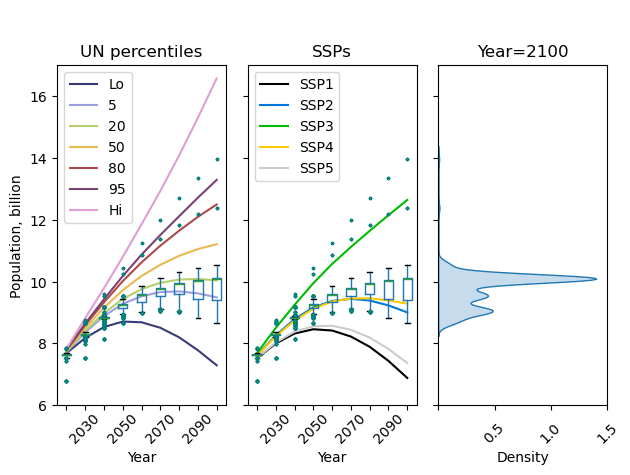

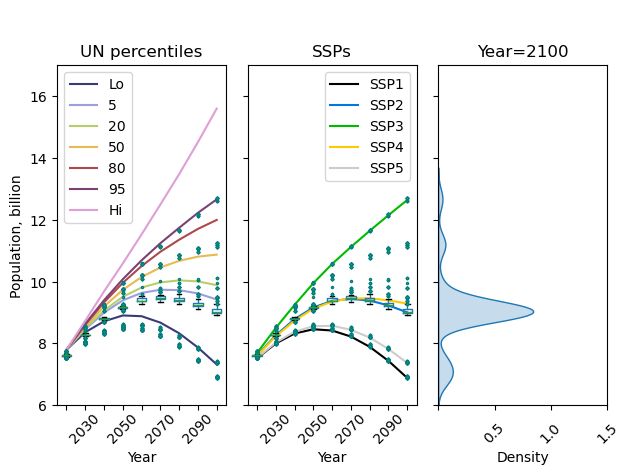

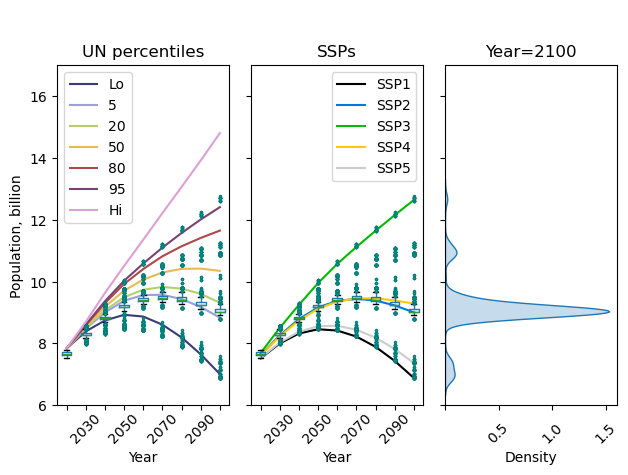

In [27]:
SSPgroupst = transformSSP(SSPgroups, region, years, "Population")
SSPgroupst["Population"] *= 1/1000

scenarios1 = ["Low variant", "5", "20", "50", "80", "95", "High variant"]
label_scenarios1 = ["Lo",
                    "5", 
                    "20", 
                    "50", 
                    "80", 
                    "95",
                    "Hi"
]
scenarios2 = ["SSP1", "SSP2", "SSP3", "SSP4", "SSP5"]
label_scenarios2 = [ "SSP1",
                    "SSP2", 
                    "SSP3", 
                    "SSP4", 
                    "SSP5",]
fignames = ["AR5world.png", "SR15world.png", "AR6world.png"]
fig = plot_2ars(ar5HIt, pd.concat((undata2015,undata2015_ext)), SSPgroupst, "WORLD", 
         scenarios1, label_scenarios1, scenarios2, label_scenarios2,
         (6,17), "Population, billion", years)
fig.savefig(os.path.join(path_for_figure, fignames[0]), dpi=300)
plot_2ars(ar15HIt, pd.concat((undata2019,undata2019_ext)), SSPgroupst, "WORLD", 
         scenarios1, label_scenarios1, scenarios2, label_scenarios2,
         (6,17), "Population, billion", years)
fig.savefig(os.path.join(path_for_figure, fignames[1]), dpi=300)
plot_2ars(ar6HIt, pd.concat((undata2022,undata2022_ext)), SSPgroupst, "WORLD", 
         scenarios1, label_scenarios1, scenarios2, label_scenarios2,
         (6,17), "Population, billion", years)
fig.savefig(os.path.join(path_for_figure, fignames[2]), dpi=300)

Test with new SSPs

blur


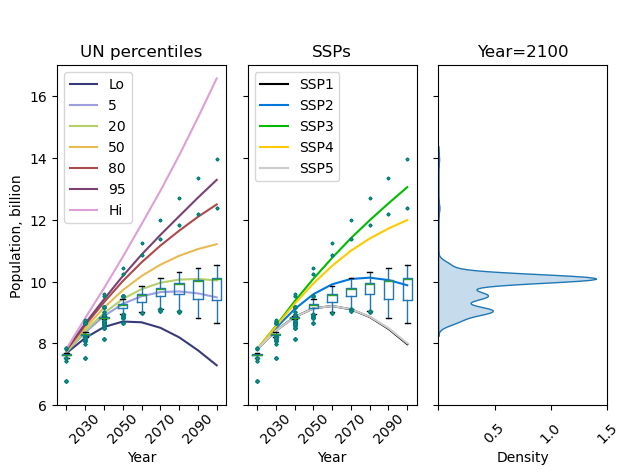

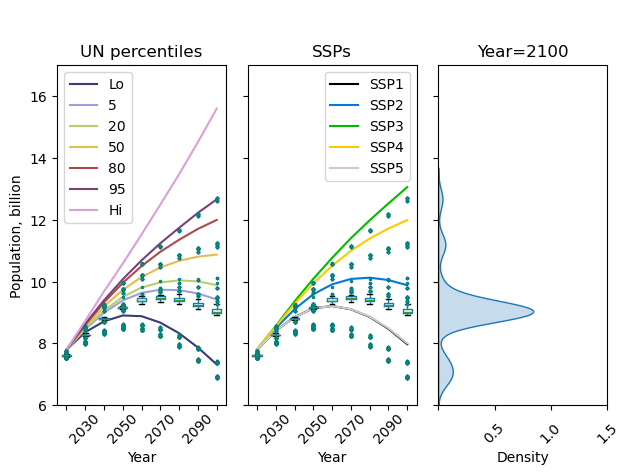

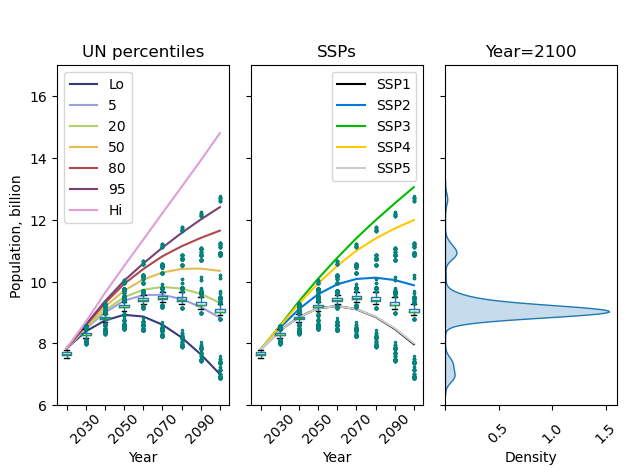

In [28]:
region = "WORLD"
SSPgroupstnew = transformSSP(SSPvnew, region, years, "Population")
SSPgroupstnew["Population"] *= 1/1000

scenarios1 = ["Low variant", "5", "20", "50", "80", "95", "High variant"]
label_scenarios1 = ["Lo",
                    "5", 
                    "20", 
                    "50", 
                    "80", 
                    "95",
                    "Hi"
]
scenarios2 = ["SSP1", "SSP2", "SSP3", "SSP4", "SSP5"]
label_scenarios2 = [ "SSP1",
                    "SSP2", 
                    "SSP3", 
                    "SSP4", 
                    "SSP5",]
fignames = ["AR5world_new.png", "SR15world_new.png", "AR6world_new.png"]
fig = plot_2ars(ar5HIt, pd.concat((undata2015,undata2015_ext)), SSPgroupstnew, "WORLD", 
         scenarios1, label_scenarios1, scenarios2, label_scenarios2,
         (6,17), "Population, billion", years)
fig.savefig(os.path.join(path_for_figure, fignames[0]), dpi=300)
plot_2ars(ar15HIt, pd.concat((undata2019,undata2019_ext)), SSPgroupstnew, "WORLD", 
         scenarios1, label_scenarios1, scenarios2, label_scenarios2,
         (6,17), "Population, billion", years)
fig.savefig(os.path.join(path_for_figure, fignames[1]), dpi=300)
plot_2ars(ar6HIt, pd.concat((undata2022,undata2022_ext)), SSPgroupstnew, "WORLD", 
         scenarios1, label_scenarios1, scenarios2, label_scenarios2,
         (6,17), "Population, billion", years)
fig.savefig(os.path.join(path_for_figure, fignames[2]), dpi=300)

Old SSPs

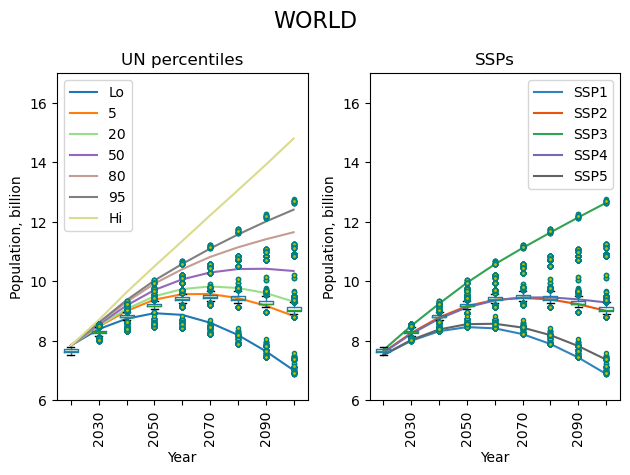

In [29]:
region = "WORLD"
w2022_1t = transformUN(w2022_1, "WORLD", True)
w2022_1extt = transformUN(w2022_1ext, "WORLD", True)

w2022_1all = pd.concat((w2022_1t, w2022_1extt))
w2022_1all["Population"] *= 1/1000

scenarios1 = ["Low variant" , "5", "20", "50", "80", "95", "High variant"]
label_scenarios1 = ["Lo", 
                    "5", 
                    "20", 
                    "50", 
                    "80", 
                    "95",
                    "Hi"]
                    
plot_ars(ar6HIt, w2022_1all, SSPgroupst, region,
        scenarios1, label_scenarios1, scenarios2, label_scenarios2, (6,17), "Population, billion", years)

New SSPs

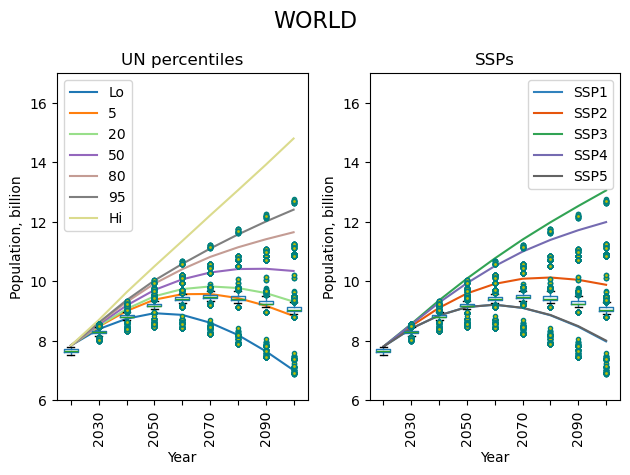

In [30]:
                  
plot_ars(ar6HIt, w2022_1all, SSPgroupstnew, region,
        scenarios1, label_scenarios1, scenarios2, label_scenarios2, (6,17), "Population, billion", years)

### Figure 6

Panel a: representation of SSPs with time

Panel b: representation of Illustrative Mitigation Pathways (IPs) with time

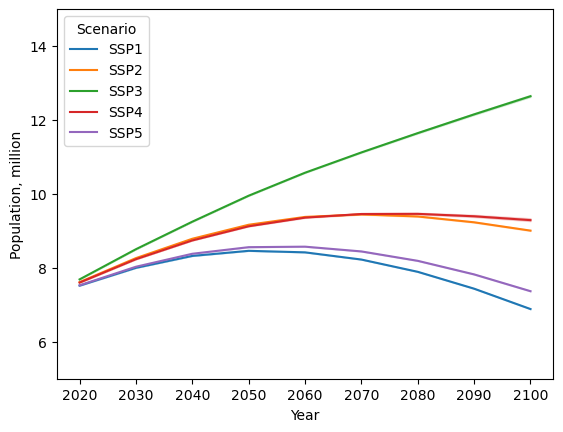

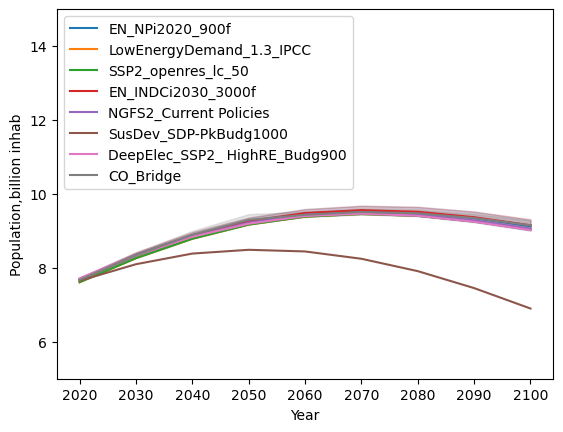

In [31]:
# represent SSP population
plt.figure(1)

ax=sns.lineplot(SSPgroupst, y="Population", x="Year", hue="Scenario", errorbar=('ci', 95), legend=True)
plt.xlabel("Year")
plt.ylabel("Population, million")
ax.set_ylim(5,15)
figname = "SSPpopulation.png"
fig.savefig(os.path.join(path_for_figure, figname), dpi=300)

plt.figure(2)
ar6emi = pd.DataFrame(ar6HI.loc[ar6HI.Variable == 'Population'])
plotyear = ["2020","2030" ,"2040", "2050", "2060", "2070", "2080", "2090", "2100"]
scenarios= list(set(ar6emi.Scenario))
imp_list = ["EN_NPi2020_400f_lowBECCS", "EN_NPi2020_900f", "NGFS2_Current Policies", "EN_INDCi2030_3000f", "LowEnergyDemand_1.3_IPCC", "SSP2_openres_lc_50",
"DeepElec_SSP2_ HighRE_Budg900", "SusDev_SDP-PkBudg1000", "CO_Bridge"]
scenarios = [m for m in scenarios if m in imp_list]
ar6emitm = pd.DataFrame() # ar6emi transpose: columns emissions and year
for y in plotyear:
    new = pd.DataFrame()
    for ms in scenarios:
        ar6emiscm = ar6emi.loc[ar6emi.Scenario==ms]
        data = ar6emiscm[y]

        data = np.array(data)/1000
        nnew = pd.DataFrame(data, columns=["Population"]).bfill()
        nnew["Scenario"] = ms

        new = pd.concat((new,nnew))

    new["Year"] = int(y)
    ar6emitm = pd.concat((ar6emitm,new))
    
ax=sns.lineplot(ar6emitm, y="Population", x="Year", hue="Scenario")
plt.xlabel("Year")
plt.ylabel("Population,billion inhab")
plt.legend(loc='upper left')
ax.set_ylim(5,15)
figname = "IP_population.png"
fig.savefig(os.path.join(path_for_figure, figname), dpi=300)

### Weighting RFF on SSPs

In [32]:
pdRFFchart = pdRFF.drop(["Series"], axis=1)

transSSP = transformSSP(SSPgroups,"WORLD", years, "Population")
transSSP["Model"] ="SSP"
transSSP = transSSP.rename(columns={"sYear": "Year"})
transSSP["Population"] *= 1/1000
SSPRFF = pd.concat((transSSP, pdRFFchart))
SSPRFF["Year"] = pd.Series(SSPRFF["Year"], dtype=int)


blur


#### Figure 9 (a) in Methods
Plots to estimate intervals of SSP scenarios to combine to obtain RFF probabilistic projections

blur


<Axes: xlabel='Year', ylabel='Population'>

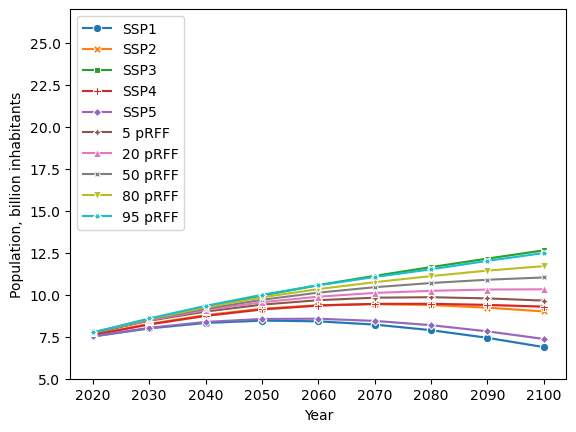

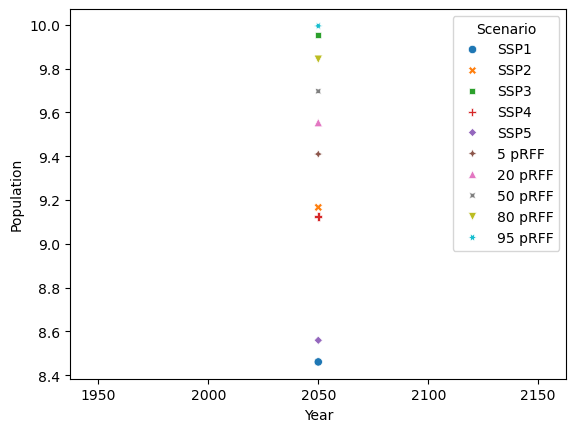

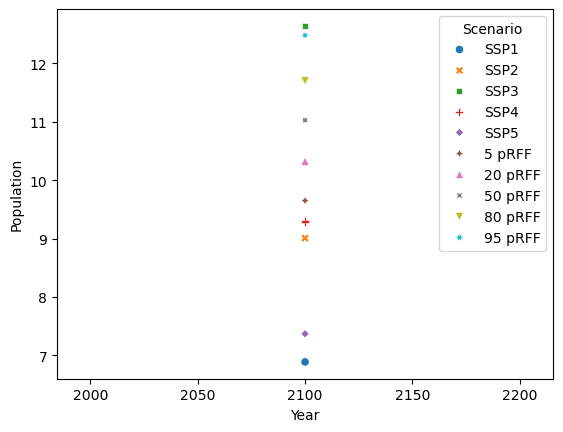

In [33]:
plt.figure(1)
ax=sns.lineplot(data=SSPRFF, x=SSPRFF.Year, y= SSPRFF.Population, hue="Scenario",  style="Scenario" ,  markers=True, dashes=False)
plt.legend(loc="upper left")
plt.ylabel("Population, billion inhabitants")
plt.xlabel("Year")
ax.set_ylim(5, 27)
# Training set represents the SSP
x_train = transformSSP(SSPgroups, "WORLD", years, "Population")
x_train["Population"] *= 1/1000
x_train = x_train.rename(columns={"sYear": "Year"})
x_train["Year"] = pd.Series(x_train["Year"],dtype=int)
group =[ "Year", "Scenario"]
X = x_train.groupby(by=group)['Population'].mean().reset_index()
figname = "SSP_RFF_chart_globallabels.png"
fig.savefig(os.path.join(path_for_figure, figname), dpi=300)

plt.figure (2)
X2050 = pd.DataFrame(X.loc[X.Year==2050])
X2050["Model"] = "SSP"
pdRFF2050 = pdRFF.loc[pdRFF.Year==2050].drop(["Series"], axis=1)

data2050 = pd.concat((X2050,pdRFF2050), axis=0)

sns.scatterplot(data2050, x=data2050.Year, y=data2050.Population, hue="Scenario", style="Scenario")


X2100 = pd.DataFrame(X.loc[X.Year==2100])
X2100["Model"] = "SSP"
pdRFF2100 = pdRFF.loc[pdRFF.Year==2100].drop(["Series"], axis=1)

data2100 = pd.concat((X2100,pdRFF2100), axis=0)
plt.figure (3)
sns.scatterplot(data2100, x=data2100.Year, y=data2100.Population, hue="Scenario", style="Scenario")


RFF quantiles are in between these SSPs

95 (SSP3, SSP4)

80 (SSP3, SSP4)

50 (SSP3, SSP4)

20 (SSP3, SSP4)

5  (SSP3, SSP4)

#### Use minimize function to determine weighting factors of SSPs to equal RFF distribution
Relevant scenarios from RFF study belong to the subset SSP3, SSP4

In [34]:

import scipy.optimize as opt

selected_scenarios = ["SSP2", "SSP3"]
nsample = len(selected_scenarios)

X = X[X["Scenario"].isin(selected_scenarios)]

def f2020(x: np.array):
    xi = np.array(X.loc[(X.Year==2020)]["Population"])
    y = np.array(pdRFF.loc[(pdRFF.Year==2020) & (pdRFF.Scenario==label)]["Population"])
    return np.power((np.dot(x,xi) - y), 2)

def f2030(x: np.array):
    xi = np.array(X.loc[(X.Year==2030)]["Population"])
    y = np.array(pdRFF.loc[(pdRFF.Year==2030) & (pdRFF.Scenario==label)]["Population"])
    return np.power((np.dot(x,xi) - y), 2)

def f2040(x: np.array):
    xi = np.array(X.loc[(X.Year==2040)]["Population"])
    y = np.array(pdRFF.loc[(pdRFF.Year==2040) & (pdRFF.Scenario==label)]["Population"])
    return np.power((np.dot(x,xi) - y), 2)

def f2050(x: np.array):
    xi = np.array(X.loc[(X.Year==2050)]["Population"])
    y = np.array(pdRFF.loc[(pdRFF.Year==2050) & (pdRFF.Scenario==label)]["Population"])
    return np.power((np.dot(x,xi) - y), 2)

def f2060(x: np.array):
    xi = np.array(X.loc[(X.Year==2060)]["Population"])
    y = np.array(pdRFF.loc[(pdRFF.Year==2060) & (pdRFF.Scenario==label)]["Population"])
    return np.power((np.dot(x,xi) - y), 2)

def f2070(x: np.array):
    xi = np.array(X.loc[(X.Year==2070)]["Population"])
    y = np.array(pdRFF.loc[(pdRFF.Year==2070) & (pdRFF.Scenario==label)]["Population"])
    return np.power((np.dot(x,xi) - y), 2)

def f2080(x: np.array):
    xi = np.array(X.loc[(X.Year==2080)]["Population"])
    y = np.array(pdRFF.loc[(pdRFF.Year==2080) & (pdRFF.Scenario==label)]["Population"])
    return np.power((np.dot(x,xi) - y), 2)

def f2090(x: np.array):
    xi = np.array(X.loc[(X.Year==2090)]["Population"])
    y = np.array(pdRFF.loc[(pdRFF.Year==2090) & (pdRFF.Scenario==label)]["Population"])
    return np.power((np.dot(x,xi) - y), 2)

def f2100(x: np.array):
    xi = np.array(X.loc[(X.Year==2100)]["Population"])
    y = np.array(pdRFF.loc[(pdRFF.Year==2100) & (pdRFF.Scenario==label)]["Population"])
    return np.power((np.dot(x,xi) - y), 2)

bounds=[(0.01,1), (0.01,1)]
scenarios = np.array(selected_scenarios).reshape(-1,1)
reslabel = pd.DataFrame()

pdRFFlabels = ["5 pRFF", "20 pRFF", "50 pRFF", "80 pRFF", "95 pRFF"]
for label in pdRFFlabels:
    res2020 = opt.minimize(f2020, x0=np.repeat(np.array(0.1), repeats=nsample), method='Nelder-Mead', tol=1e-6, bounds=bounds)
    res2030 = opt.minimize(f2030, x0=np.repeat(np.array(0.1), repeats=nsample), method='Nelder-Mead', tol=1e-6, bounds=bounds)
    res2040 = opt.minimize(f2040, x0=np.repeat(np.array(0.1), repeats=nsample), method='Nelder-Mead', tol=1e-6, bounds=bounds)
    res2050 = opt.minimize(f2050, x0=np.repeat(np.array(0.1), repeats=nsample), method='Nelder-Mead', tol=1e-6, bounds=bounds)
    res2060 = opt.minimize(f2060, x0=np.repeat(np.array(0.1), repeats=nsample), method='Nelder-Mead', tol=1e-6, bounds=bounds)
    res2070 = opt.minimize(f2070, x0=np.repeat(np.array(0.1), repeats=nsample), method='Nelder-Mead', tol=1e-6, bounds=bounds)
    res2080 = opt.minimize(f2080, x0=np.repeat(np.array(0.1), repeats=nsample), method='Nelder-Mead', tol=1e-6, bounds=bounds)
    res2090 = opt.minimize(f2090, x0=np.repeat(np.array(0.1), repeats=nsample), method='Nelder-Mead', tol=1e-6, bounds=bounds)
    res2100 = opt.minimize(f2100, x0=np.repeat(np.array(0.1), repeats=nsample), method='Nelder-Mead', tol=1e-6, bounds=bounds)
    data2020 = res2020.x.reshape(1,-1)
    data2030 = res2030.x.reshape(1,-1)
    data2040 = res2040.x.reshape(1,-1)
    data2050 = res2050.x.reshape(1,-1)
    data2060 = res2060.x.reshape(1,-1)
    data2070 = res2070.x.reshape(1,-1)
    data2080 = res2080.x.reshape(1,-1)
    data2090 = res2090.x.reshape(1,-1)
    data2100 = res2100.x.reshape(1,-1)
    resall = np.concatenate((data2020, data2030, data2040, data2050, data2060, data2070, data2080, data2090, data2100), axis=0)
    resallframe = pd.DataFrame(data=resall, columns=np.array(["SSP2", "SSP3"]).reshape(-1,1), index=np.repeat([label], 9))
    resallframe["Year"] = years
    reslabel = pd.concat((reslabel,resallframe), axis=0)
reslabel = reslabel.reset_index()
reslabel.columns = ["Scenario", "SSP2", "SSP3", "Year"]
selected_years = [2050]
data = reslabel[reslabel.Year.isin(selected_years)]


#### Representing weighting factors of RFF over SSPs

<Figure size 640x480 with 0 Axes>

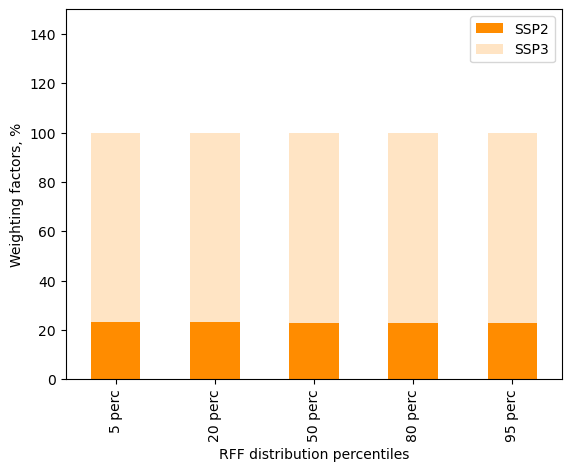

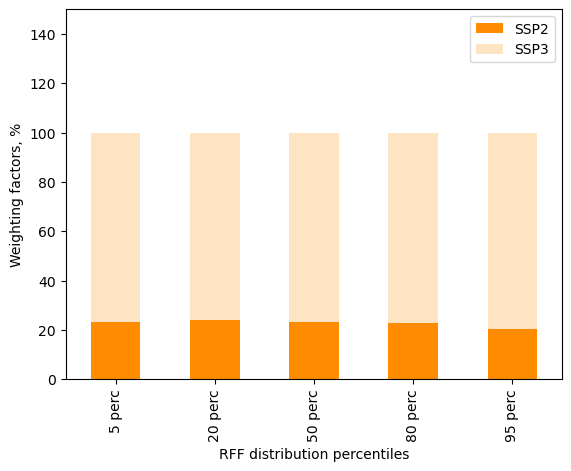

In [35]:

plt.figure (4)
chart  = pd.DataFrame()
for s, scenario in enumerate(pdRFFlabels):
    for y in selected_years:
        datas = pd.DataFrame(data.loc[(data.Scenario == scenario) & (data.Year==y)])
        datas["SSP2"] = pd.Series(datas["SSP2"] * 100)
        datas["SSP3"] = pd.Series(datas["SSP3"] * 100)
        chart = pd.concat((chart,datas))
        chart = chart.drop("Year", axis=1)
chart["sum"] =  chart["SSP2"] + chart["SSP3"]
chart["SSP2"] *= 100/chart["sum"]
chart["SSP3"] *= 100/chart["sum"]
chart=chart.drop("sum", axis=1)
colours = ["darkorange", "bisque",
            "salmon", "mistyrose",
            "olivedrab", "darkseagreen",
            "cadetblue", "lightcyan",
            "slategrey", "lightsteelblue" ]
ax=chart.plot(kind="bar", stacked=True, color=colours )
plt.xticks(ticks=np.array([0,1,2,3,4]),
           labels=["5 perc", "20 perc", "50 perc", "80 perc",  "95 perc"])
ax.set_ylim(0,150)
plt.xlabel("RFF distribution percentiles")
plt.ylabel("Weighting factors, %")
figname = "SSP_RFF_share2050.png"
fig.savefig(os.path.join(path_for_figure, figname), dpi=300)

plt.figure(5)
selected_years = [2100]
data = reslabel[reslabel.Year.isin(selected_years)]

chart  = pd.DataFrame()
for s, scenario in enumerate(pdRFFlabels):
    for y in selected_years:
        datas = pd.DataFrame(data.loc[(data.Scenario == scenario) & (data.Year==y)])
        datas["SSP2"] = pd.Series(datas["SSP2"] * 100)
        datas["SSP3"] = pd.Series(datas["SSP3"] * 100)
        chart = pd.concat((chart,datas))
        chart = chart.drop("Year", axis=1)
chart["sum"] =  chart["SSP2"] + chart["SSP3"]
chart["SSP2"] *= 100/chart["sum"]
chart["SSP3"] *= 100/chart["sum"]
chart=chart.drop("sum", axis=1)
colours = ["darkorange", "bisque",
            "salmon", "mistyrose",
            "olivedrab", "darkseagreen",
            "cadetblue", "lightcyan",
            "slategrey", "lightsteelblue" ]
ax=chart.plot(kind="bar", stacked=True, color=colours )
plt.xticks(ticks=np.array([0,1,2,3,4]),
           labels=["5 perc", "20 perc", "50 perc", "80 perc",  "95 perc"])
ax.set_ylim(0, 150)
plt.xlabel("RFF distribution percentiles")
plt.ylabel("Weighting factors, %")
figname = "SSP_RFF_share2100.png"
fig.savefig(os.path.join(path_for_figure, figname), dpi=300)

### Weighting UN on SSPs

#### Represent scenario trends of UN probabilistic and SSPs

blur


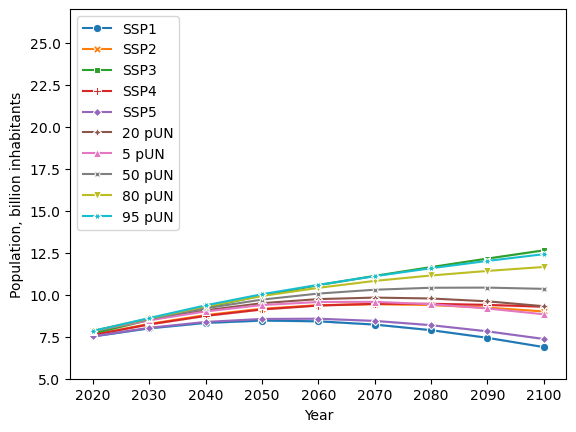

In [36]:
# UN probabilistic
undata = transformUN(w2022_1, "WORLD", True)
undata["Model"] = "pUN"
change = {"5": "5 pUN", "20": "20 pUN", "50": "50 pUN", "80": "80 pUN", "95": "95 pUN"}
undata["Series"] = undata["Scenario"]
undata = undata[pdRFF.columns]
for ch in change.keys():
    undata["Scenario"] = undata["Scenario"].replace(ch, change[ch])

change = {"5": 0.05, "20": 0.02, "50": 0.5, "80": 0.8, "95": 0.95}
for ch in change.keys():
    undata["Series"] = undata["Series"].replace(ch, change[ch])

undata = undata.drop("Series",axis=1)
undata["Population"] *= 1/1000

#UN extremes
remove_scenarios = ['Constant-fertility', 'Instant-replacement', 'Instant-replacement zero migr', 'No change']
undata_ext, sel_labels = transformUNminmax(w2022_1ext, "WORLD", False, remove_scenarios)
undata_ext["Model"] = "dUN"
undata_ext["Population"] *= 1/1000


transSSP = transformSSP(SSPgroups,"WORLD", years, "Population")
transSSP["Population"] *= 1/1000
transSSP["Model"] = "SSP"

SSPUN= pd.concat((transSSP,undata))
SSPUN["Year"] = pd.Series(SSPUN["Year"], dtype=int)
ax=sns.lineplot(data=SSPUN, x=SSPUN.Year, y= SSPUN.Population, hue="Scenario",  style="Scenario" ,  markers=True, dashes=False)
plt.legend(loc="upper left")
plt.ylabel("Population, billion inhabitants")
plt.xlabel("Year")
ax.set_ylim(5, 27)

figname = "SSP_UN_chart_globallabels.png"
fig.savefig(os.path.join(path_for_figure, figname), dpi=300)

#### Plots to estimate intervals of SSP scenarios to combine to obtain UN probabilistic projections

blur
blur


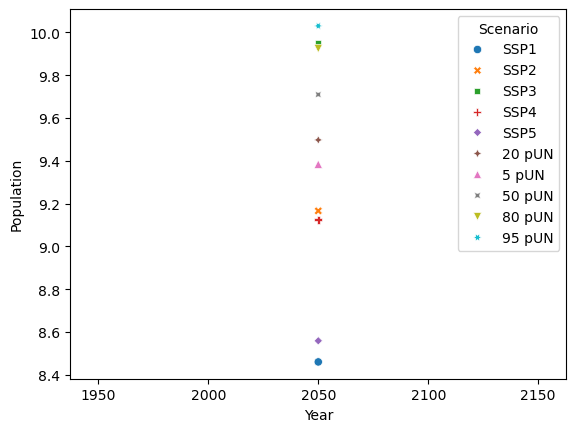

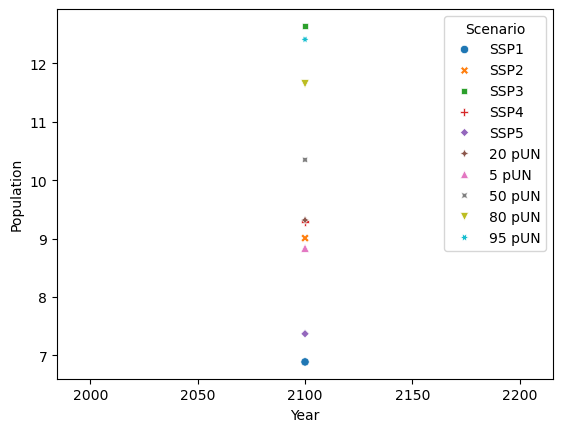

In [37]:
## 2050
undata2100 = pd.DataFrame(undata.loc[undata.Year==2050])
x_train = transformSSP(SSPgroups, "WORLD", years, "Population")
x_train["Population"] *= 1/1000
x_train = x_train.rename(columns={"sYear": "Year"})
x_train["Year"] = pd.Series(x_train["Year"],dtype=int)
group =[ "Year", "Scenario"]
X = x_train.groupby(by=group)['Population'].mean().reset_index()
X2100 = pd.DataFrame(X.loc[X.Year==2050])
X2100["Model"] = "SSP"

plt.figure(1)
databis2100 = pd.concat((X2100,undata2100), axis=0)
sns.scatterplot(databis2100, x=databis2100.Year, y=databis2100.Population, hue="Scenario", style="Scenario")

databis2100 = databis2100.sort_values("Population")

## 2100
undata2100 = pd.DataFrame(undata.loc[undata.Year==2100])
x_train = transformSSP(SSPgroups, "WORLD", years, "Population")
x_train["Population"] *= 1/1000
x_train = x_train.rename(columns={"sYear": "Year"})
x_train["Year"] = pd.Series(x_train["Year"],dtype=int)
group =[ "Year", "Scenario"]
X = x_train.groupby(by=group)['Population'].mean().reset_index()
X2100 = pd.DataFrame(X.loc[X.Year==2100])
X2100["Model"] = "SSP"
plt.figure(2)
databis2100 = pd.concat((X2100,undata2100), axis=0)
sns.scatterplot(databis2100, x=databis2100.Year, y=databis2100.Population, hue="Scenario", style="Scenario")
databis2100 = databis2100.sort_values("Population")



#### Use minimize function on weighting factors for SSPs to determine UN probabilistic projections

In [38]:
# Relevant scenarios from RFF study belong to the subset SSP3, SSP4

import scipy.optimize as opt

sdict = {
"5 pUN": ["SSP5", "SSP2", "SSP3"],
"20 pUN": ["SSP5", "SSP2", "SSP3"],
"50 pUN": ["SSP5", "SSP2", "SSP3"],
"80 pUN": ["SSP5", "SSP2", "SSP3"],
"95 pUN": ["SSP5", "SSP2", "SSP3"],}

bdict = {
"5 pUN": [(0.0,0.0),(0.0,1), (0.0,1)],
"20 pUN": [(0.0,0.0),(0.0,1), (0.0,1)],
"50 pUN": [(0.0,0.0),(0.0,1), (0.0,1)],
"80 pUN": [(0.0,0.0),(0.0,1), (0.0,1)],
"95 pUN": [(0.0,0.0),(0.0,0.0), (0.0,3)],
}

bdict2 = {
"5 pUN": [(0.0,1), (0.0,1), (0.0, 0.0)],
"20 pUN": [(0.0,0.0),(0.0,1), (0.0,1)],
"50 pUN": [(0.0,0.0),(0.0,1), (0.0,1)],
"80 pUN": [(0.0,0.0),(0.0,1), (0.0,1)],
"95 pUN": [(0.0,0.0),(0.0,1), (0.0,1)],
}


def f2020(x: np.array):
    xi = np.array(Xsel.loc[(Xsel.Year==2020)]["Population"])
    y = np.array(undata.loc[(undata.Year==2020) & (undata.Scenario==label)]["Population"])
    return np.power((np.dot(x,xi) - y), 2)

def f2030(x: np.array):
    xi = np.array(Xsel.loc[(Xsel.Year==2030)]["Population"])
    y = np.array(undata.loc[(undata.Year==2030) & (undata.Scenario==label)]["Population"])
    return np.power((np.dot(x,xi) - y), 2)

def f2040(x: np.array):
    xi = np.array(Xsel.loc[(Xsel.Year==2040)]["Population"])
    y = np.array(undata.loc[(undata.Year==2040) & (undata.Scenario==label)]["Population"])
    return np.power((np.dot(x,xi) - y), 2)

def f2050(x: np.array):
    xi = np.array(Xsel.loc[(Xsel.Year==2050)]["Population"])
    y = np.array(undata.loc[(undata.Year==2050) & (undata.Scenario==label)]["Population"])
    return np.power((np.dot(x,xi) - y), 2)

def f2060(x: np.array):
    xi = np.array(Xsel.loc[(Xsel.Year==2060)]["Population"])
    y = np.array(undata.loc[(undata.Year==2060) & (undata.Scenario==label)]["Population"])
    return np.power((np.dot(x,xi) - y), 2)

def f2070(x: np.array):
    xi = np.array(Xsel.loc[(Xsel.Year==2070)]["Population"])
    y = np.array(undata.loc[(undata.Year==2070) & (undata.Scenario==label)]["Population"])
    return np.power((np.dot(x,xi) - y), 2)

def f2080(x: np.array):
    xi = np.array(Xsel.loc[(Xsel.Year==2080)]["Population"])
    y = np.array(undata.loc[(undata.Year==2080) & (undata.Scenario==label)]["Population"])
    return np.power((np.dot(x,xi) - y), 2)

def f2090(x: np.array):
    xi = np.array(Xsel.loc[(Xsel.Year==2090)]["Population"])
    y = np.array(undata.loc[(undata.Year==2090) & (undata.Scenario==label)]["Population"])
    return np.power((np.dot(x,xi) - y), 2)

def f2100(x: np.array):
    xi = np.array(Xsel.loc[(Xsel.Year==2100)]["Population"])
    y = np.array(undata.loc[(undata.Year==2100) & (undata.Scenario==label)]["Population"])
    return np.power((np.dot(x,xi) - y), 2)


reslabel = pd.DataFrame()

UNlabels = ["5 pUN", "20 pUN", "50 pUN", "80 pUN", "95 pUN"]
for label in UNlabels:
    selected_scenarios = sdict[label]
    Xsel = X[X["Scenario"].isin(selected_scenarios)]
    nsample = len(selected_scenarios)
    bounds = bdict[label]
    bounds2 = bdict2[label]

    bounds = bdict[label]
    bounds2 = bdict2[label]
    res2020 = opt.minimize(f2020, x0=np.repeat(np.array(0.0), repeats=nsample), method='Nelder-Mead', tol=1e-6, bounds=bounds)
    res2030 = opt.minimize(f2030, x0=np.repeat(np.array(0.0), repeats=nsample), method='Nelder-Mead', tol=1e-6, bounds=bounds)
    res2040 = opt.minimize(f2040, x0=np.repeat(np.array(0.0), repeats=nsample), method='Nelder-Mead', tol=1e-6, bounds=bounds)
    res2050 = opt.minimize(f2050, x0=np.repeat(np.array(0.0), repeats=nsample), method='Nelder-Mead', tol=1e-6, bounds=bounds)
    res2060 = opt.minimize(f2060, x0=np.repeat(np.array(0.0), repeats=nsample), method='Nelder-Mead', tol=1e-6, bounds=bounds)
    res2070 = opt.minimize(f2070, x0=np.repeat(np.array(0.0), repeats=nsample), method='Nelder-Mead', tol=1e-6, bounds=bounds)
    res2080 = opt.minimize(f2080, x0=np.repeat(np.array(0.0), repeats=nsample), method='Nelder-Mead', tol=1e-6, bounds=bounds)
    res2090 = opt.minimize(f2090, x0=np.repeat(np.array(0.0), repeats=nsample), method='Nelder-Mead', tol=1e-6, bounds=bounds)
    res2100 = opt.minimize(f2100, x0=np.repeat(np.array(0.0), repeats=nsample), method='Nelder-Mead', tol=1e-6, bounds=bounds2)
    data2020 = res2020.x.reshape(1,-1)
    data2030 = res2030.x.reshape(1,-1)
    data2040 = res2040.x.reshape(1,-1)
    data2050 = res2050.x.reshape(1,-1)
    data2060 = res2060.x.reshape(1,-1)
    data2070 = res2070.x.reshape(1,-1)
    data2080 = res2080.x.reshape(1,-1)
    data2090 = res2090.x.reshape(1,-1)
    data2100 = res2100.x.reshape(1,-1)
    resall = np.concatenate((data2020, data2030, data2040, data2050, data2060, data2070, data2080, data2090, data2100), axis=0)
    resallframe = pd.DataFrame(data=resall, columns=np.array(selected_scenarios).reshape(-1,1), index=np.repeat([label], 9))
    resallframe["Year"] = years
    reslabel = pd.concat((reslabel,resallframe), axis=0)
reslabel = reslabel.reset_index()

reslabel = reslabel.rename(columns={reslabel.columns[0]: "Scenario",reslabel.columns[1]: "SSP5", reslabel.columns[2]:"SSP2", 
    reslabel.columns[3]:"SSP3"})
reslabel = reslabel.fillna(0)
reslabel = reslabel[["Scenario", "Year",  "SSP5", "SSP2", "SSP3"]]

selected_years = [2050]
data = reslabel[reslabel.Year.isin(selected_years)]

#### Figure 10 (a, b) in Methods

<Figure size 640x480 with 0 Axes>

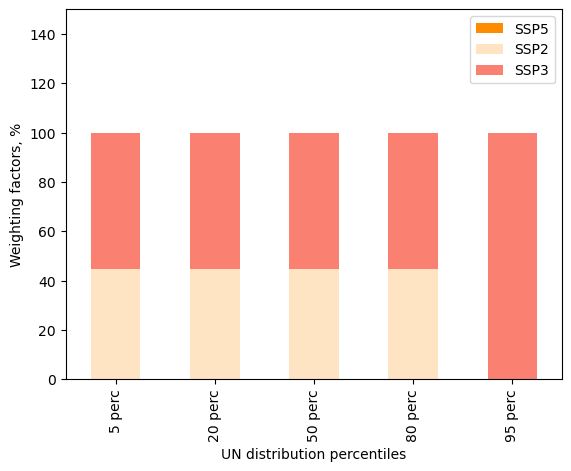

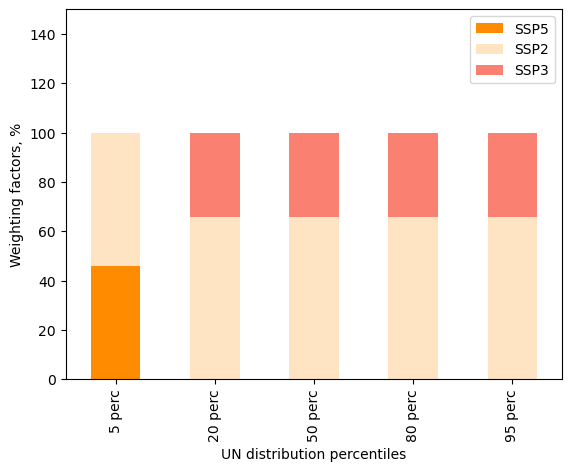

In [39]:
plt.figure (1)
chart  = pd.DataFrame()
for s, scenario in enumerate(UNlabels):
    for y in selected_years:
        datas = pd.DataFrame(data.loc[(data.Scenario == scenario) & (data.Year==y)])
        datas["SSP5"] = pd.Series(datas["SSP5"] * 100)
        datas["SSP2"] = pd.Series(datas["SSP2"] * 100)
        datas["SSP3"] = pd.Series(datas["SSP3"] * 100)
        chart = pd.concat((chart,datas))
        chart = chart.drop("Year", axis=1)
chart["sum"] =  chart["SSP5"] + chart["SSP2"] + chart["SSP3"]
chart["SSP5"] *= 100/chart["sum"]
chart["SSP2"] *= 100/chart["sum"]
chart["SSP3"] *= 100/chart["sum"]
chart=chart.drop("sum", axis=1)
colours = ["darkorange", "bisque",
            "salmon", "mistyrose",
            "olivedrab", "darkseagreen",
            "cadetblue", "lightcyan",
            "slategrey", "lightsteelblue" ]
ax=chart.plot(kind="bar", stacked=True, color=colours )
plt.xticks(ticks=np.array([0,1,2,3,4]),
           labels=["5 perc", "20 perc", "50 perc", "80 perc",  "95 perc"])
ax.set_ylim(0,150)
plt.xlabel("UN distribution percentiles")
plt.ylabel("Weighting factors, %")
figname = "SSP_UN_share2050.png"
fig.savefig(os.path.join(path_for_figure, figname), dpi=300)

plt.figure(2)
selected_years = [2100]
data = reslabel[reslabel.Year.isin(selected_years)]

chart  = pd.DataFrame()
for s, scenario in enumerate(UNlabels):
    for y in selected_years:
        datas = pd.DataFrame(data.loc[(data.Scenario == scenario) & (data.Year==y)])
        datas["SSP5"] = pd.Series(datas["SSP5"] * 100)
        datas["SSP2"] = pd.Series(datas["SSP2"] * 100)
        datas["SSP3"] = pd.Series(datas["SSP3"] * 100)
        chart = pd.concat((chart,datas))
        chart = chart.drop("Year", axis=1)
chart["sum"] =  chart["SSP5"] + chart["SSP2"] + chart["SSP3"]
chart["SSP5"] *= 100/chart["sum"]
chart["SSP2"] *= 100/chart["sum"]
chart["SSP3"] *= 100/chart["sum"]
chart=chart.drop("sum", axis=1)

colours = ["darkorange", "bisque",
            "salmon", "mistyrose",
            "olivedrab", "darkseagreen",
            "cadetblue", "lightcyan",
            "slategrey", "lightsteelblue" ]
ax=chart.plot(kind="bar", stacked=True, color=colours )
plt.xticks(ticks=np.array([0,1,2,3,4]),
           labels=["5 perc", "20 perc", "50 perc", "80 perc",  "95 perc"])
ax.set_ylim(0, 150)
plt.xlabel("UN distribution percentiles")
plt.ylabel("Weighting factors, %")
figname = "SSP_UN_share2100.png"
fig.savefig(os.path.join(path_for_figure, figname), dpi=300)


### Figure 11 in Methods
General statistics on counting scenarios per assessment report

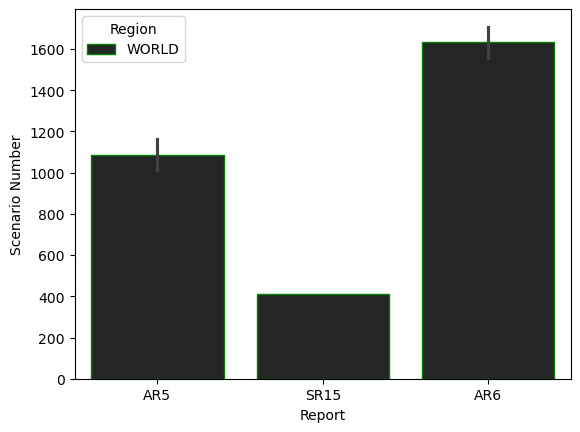

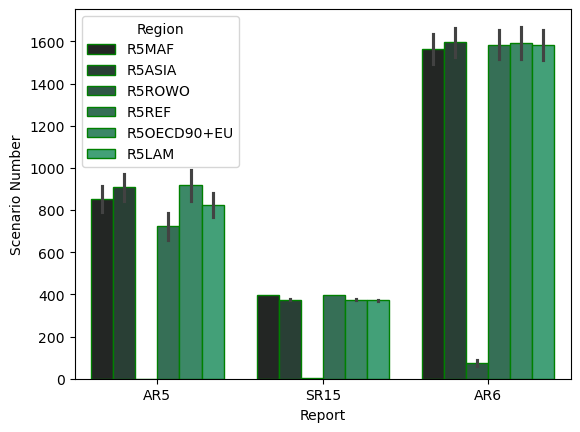

In [40]:
ar5 = counts(ar5HI, "WORLD")
sr15 = counts(ar15HI, "WORLD")
ar6 = counts(ar6HI, "WORLD")

globcount = pd.concat((pd.concat((ar5,sr15)), ar6))
globcount = globcount.reset_index()
globcount = globcount.rename(columns={"index": "Report"})

regcount = pd.DataFrame()
for region in list(set(ar6reg5HI.Region)):  
    ar5reg = counts(ar5HI, region)
    sr15reg = counts(ar15HI, region)
    ar6reg = counts(ar6reg5HI, region)
    regcount = pd.concat((regcount, 
               pd.concat((pd.concat((ar5reg,sr15reg)), ar6reg))))
regcount = regcount.reset_index()
regcount = regcount.rename(columns={"index": "Report"})

plt.figure(1)
colours = sns.color_palette("husl", 5)[2]
sns.barplot(globcount, x="Report", y="Scenario Number", hue="Region", palette="dark:#33b07a", edgecolor="green")
figname = "globalscenarionumber.png"
fig.savefig(os.path.join(path_for_figure, figname), dpi=300)
plt.figure(2)
colours = sns.color_palette("husl", 5)[2]
sns.barplot(regcount, x="Report", y="Scenario Number", hue="Region", palette="dark:#33b07a", edgecolor="green")
figname = "regionalscenarionumber.png"
fig.savefig(os.path.join(path_for_figure, figname), dpi=300)

## Part 5: Statistical analysis of assessment reports at a regional level

Regional deviations:

- Calculation made for 2020 for AR5, SR 1.5, and AR6 for 5 regions

- Calculation made for 2020 for AR6 10 regions

### Figure 14 (a, c)
Estimation of regional errors using UN as a basis

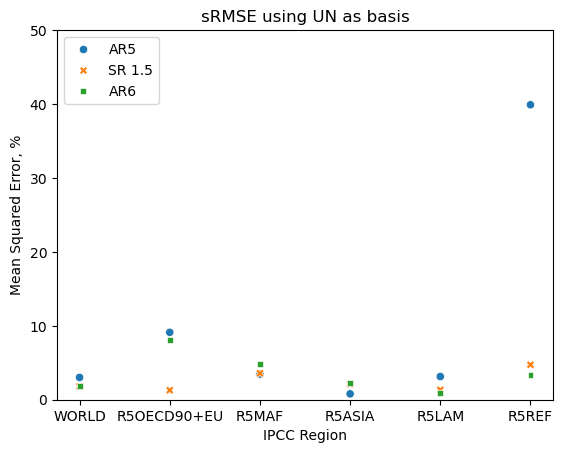

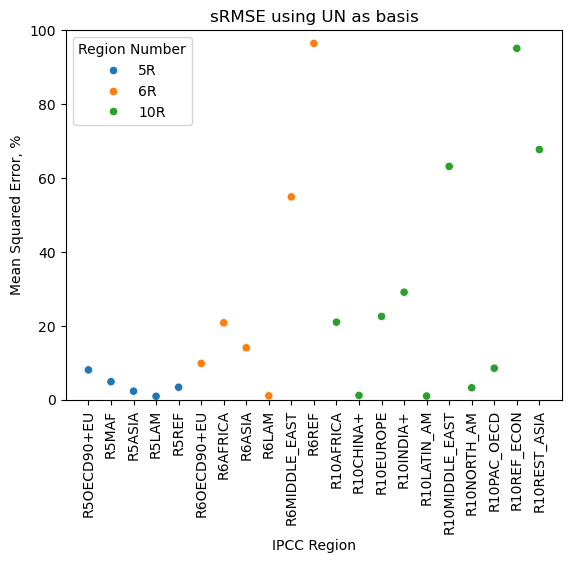

In [41]:
# world
samples = [ar5HIt, ar15HIt, ar6HIt]
datasets = ["AR5", "SR 1.5", "AR6"]
un_databases = [w2022_5, w2015_5, w2019_5]
region = "WORLD"
year = 2020
threshold = (0.005, 0.995)
scaler = 1000
untype = "UN"
output = pd.DataFrame()
for s, sample in enumerate(samples):
    dataset = datasets[s]
    samplet = sample.copy(deep=True)
    err = np.array(data_error(un_databases[s], 
                                samplet, 
                                year, 
                                threshold, 
                                region, 
                                dataset, 
                                scaler,
                                untype))
    err = err.reshape(1, len(err))
    pderr = pd.DataFrame(err, columns=["MAE", "MSE", "sRMSE"], index=[dataset])
    pderr["IPCCRegion"] = region
    output = pd.concat((output, pderr), axis=0)

outputworld = output.copy(deep=True)
pad = pd.DataFrame(outputworld["sRMSE"].values.reshape(-1,1).transpose(),columns=np.array(["AR5", "SR 1.5", "AR6"]), index=["WORLD"])

# 5 regions
samples = [ar5HI, ar15HI, ar6reg5HI]
datasets = ["AR5", "SR 1.5", "AR6"]
un_databases = [r2015_5, r2019_5, r2022_5]
regions = ['R5OECD90+EU', 'R5MAF', 'R5ASIA', 'R5LAM', 'R5REF']
year = 2020
threshold = (0.25, 0.75)
scaler = 1
untype = "UN"
output = pd.DataFrame()
for region in regions:
    newc = pd.DataFrame()
    for s, sample in enumerate(samples):
        samplet = transformAR(sample,region, dataset, threshold, [year], "Population", "Population")
        dataset = datasets[s]
        err = np.array(data_error(un_databases[s], 
                                  samplet, 
                                  year, 
                                  threshold, 
                                  region, 
                                  dataset, 
                                  scaler,
                                  untype))
        err = err.reshape(1, len(err))
        pderr = pd.DataFrame(err, columns=["MAE", "MSE", "sRMSE"], index=[dataset])
        pderr["IPCCRegion"] =region
        output = pd.concat((output, pderr), axis=0)
        new = pd.DataFrame(pderr["sRMSE"].values.reshape(-1,1).transpose(),columns=[dataset], index=[region])
        newc = pd.concat((newc,new), axis=1)
    pad = pd.concat((pad, newc),axis=0)
outputr = output.copy(deep=True)

output = pd.concat((outputworld, outputr), axis=0)
output = output.reset_index()
output.columns = ["IPCC Report", "MAE", "MSE", "sRMSE", "IPCC Region"]

plt.figure (1)
ax=sns.scatterplot(data=pad)
plt.ylabel("Mean Squared Error, %")
plt.xlabel("IPCC Region")
plt.legend(loc='upper left')
ax.set_ylim(0, 50)
plt.title("sRMSE using UN as basis")
figname = "rmse_allreport.png"
fig.savefig(os.path.join(path_for_figure, figname), dpi=300)

# 5,6,10 regions
samples = [ar6reg5HI, ar6reg6HI, ar6reg10HI]
datasets = ["5R", "6R", "10R"]
un_databases = [r2022_5, r2022_6, r2022_10]
regions5 = ['R5OECD90+EU',
            'R5MAF', 
            'R5ASIA', 
            'R5LAM', 
            'R5REF']

regions6 = ['R6OECD90+EU',
            'R6AFRICA', 
            'R6ASIA',
            'R6LAM',
            'R6MIDDLE_EAST',
            'R6REF']

regions10 = [  "R10AFRICA",  	"R10CHINA+",	"R10EUROPE",	
               "R10INDIA+",	    "R10LATIN_AM",	"R10MIDDLE_EAST",
               "R10NORTH_AM",	"R10PAC_OECD",	"R10REF_ECON",	"R10REST_ASIA"]

dict_sample = {datasets[0]: regions5,
               datasets[1]: regions6, 
               datasets[2]: regions10}

year = 2020
threshold = (0.25, 0.75)
scaler = 1
untype = "UN"
output = pd.DataFrame()
for s, sample in enumerate(samples):
    for region in dict_sample[datasets[s]]:
        newc = pd.DataFrame()
        dataset = datasets[s]
        samplet = transformAR(sample,region, dataset, threshold, [year], "Population", "Population")
        err = np.array(data_error(un_databases[s], 
                                  samplet, 
                                  year, 
                                  threshold, 
                                  region, 
                                  dataset, 
                                  scaler,
                                  untype))
        err = err.reshape(1, len(err))
        pderr = pd.DataFrame(err, columns=["MAE", "MSE", "sRMSE"], index=[dataset])
        pderr["IPCCRegion"] = region
        output = pd.concat((output, pderr), axis=0)
    #     new = pd.DataFrame(pderr["sRMSE"].values.reshape(-1,1).transpose(),columns=[dataset], index=[region])
    #     newc = pd.concat((newc,new), axis=1)
    # pad = pd.concat((pad, newc),axis=0)
outputr = output.copy(deep=True)

output = output.reset_index()
output.columns = ["Region Number", "MAE", "MSE", "sRMSE", "IPCC Region"]


plt.figure(2)
ax=sns.scatterplot(data=output[["Region Number", "sRMSE", "IPCC Region"]], x=output["IPCC Region"], y=output["sRMSE"], hue = output["Region Number"])
plt.ylabel("Mean Squared Error, %")
plt.xticks(rotation = 90)
plt.xlabel("IPCC Region")
plt.title("sRMSE using UN as basis")
ax.set_ylim(0, 100)
figname = "rmse_allreg.png"
fig.savefig(os.path.join(path_for_figure, figname), dpi=300)



### Figure 14 (b, d)
Comparison with SSPs and UN probabilistic projections

In [42]:
ssp_full = readSSP(years)
SSPpop = ssp_full[0]
codes = ssp_full[4]
scenarios = ssp_full[5]

SSPpopc = pd.DataFrame(SSPpop)
for o in codes.keys():
    SSPpopc["Country"]  = SSPpopc["Country"].replace(o, codes[o])

SSPpopc = SSPpopc.rename(columns={"Country": "COUNTRY"})
dict5R=createIPCC5R()
SSPpopc5R = SSPpopc.copy(deep=True)
SSPpopc5R["IPCCRegion"] = SSPpopc5R["COUNTRY"]
keys = list(dict5R.keys())[1:]
for o in keys:
    SSPpopc5R["IPCCRegion"]  = SSPpopc5R["IPCCRegion"].replace(dict5R[o],o)

dict6R=createIPCC6R()
SSPpopc6R = SSPpopc.copy(deep=True)
SSPpopc6R["IPCCRegion"] = SSPpopc6R["COUNTRY"]
keys = list(dict6R.keys())[1:]
for o in keys:
    SSPpopc6R["IPCCRegion"]  = SSPpopc6R["IPCCRegion"].replace(dict6R[o],o)

dict10R=createIPCC10R()
SSPpopc10R = SSPpopc.copy(deep=True)
SSPpopc10R["IPCCRegion"] = SSPpopc10R["COUNTRY"]
keys = list(dict10R.keys())[1:]
for o in keys:
    SSPpopc10R["IPCCRegion"]  = SSPpopc10R["IPCCRegion"].replace(dict10R[o],o)

for o in scenarios.keys():
    SSPpopc5R["SCENARIO"]  = SSPpopc5R["SCENARIO"].replace(o, scenarios[o])
    SSPpopc6R["SCENARIO"]  = SSPpopc6R["SCENARIO"].replace(o, scenarios[o])
    SSPpopc10R["SCENARIO"]  = SSPpopc10R["SCENARIO"].replace(o, scenarios[o])

remove = "PIK GDP-32"
SSPpopc5R = pd.DataFrame(SSPpopc5R .loc[SSPpopc5R.MODEL != remove])
SSPpopc6R = pd.DataFrame(SSPpopc6R .loc[SSPpopc6R.MODEL != remove])
SSPpopc10R = pd.DataFrame(SSPpopc10R .loc[SSPpopc10R.MODEL != remove])

SSPrex5=SSPpopc5R.drop(["REGION", "COUNTRY"], axis=1)
SSPrex6=SSPpopc6R.drop(["REGION", "COUNTRY"], axis=1)
SSPrex10=SSPpopc10R.drop(["REGION", "COUNTRY"], axis=1)

columns = ['MODEL', 'SCENARIO', 'IPCCRegion', 'VARIABLE', 'UNIT', '2020', '2030', '2040', '2050',
       '2060', '2070', '2080', '2090', '2100']


SSPrex5=SSPrex5[columns]
SSPrex6=SSPrex6[columns]
SSPrex10=SSPrex10[columns]

SSPrex5 = SSPrex5.groupby(["MODEL", "SCENARIO", "IPCCRegion", "UNIT"])[syears].sum().reset_index()
SSPrex6 = SSPrex6.groupby(["MODEL", "SCENARIO", "IPCCRegion", "UNIT"])[syears].sum().reset_index()
SSPrex10 = SSPrex10.groupby(["MODEL", "SCENARIO", "IPCCRegion", "UNIT"])[syears].sum().reset_index()

SSPrex5 = SSPrex5.rename(columns={"SCENARIO": "Scenario", "MODEL": "Model", "UNIT": "Unit"})
SSPrex6 = SSPrex6.rename(columns={"SCENARIO": "Scenario", "MODEL": "Model", "UNIT": "Unit"})
SSPrex10 = SSPrex10.rename(columns={"SCENARIO": "Scenario", "MODEL": "Model", "UNIT": "Unit"})


blur
blur
blur
blur
blur
blur
blur
blur
blur
blur
blur
blur
blur
blur
blur
blur
blur
blur
blur
blur
blur
blur
blur
blur
blur
blur
blur
blur
blur
blur
blur
blur
blur
blur
blur
blur
blur
blur
blur


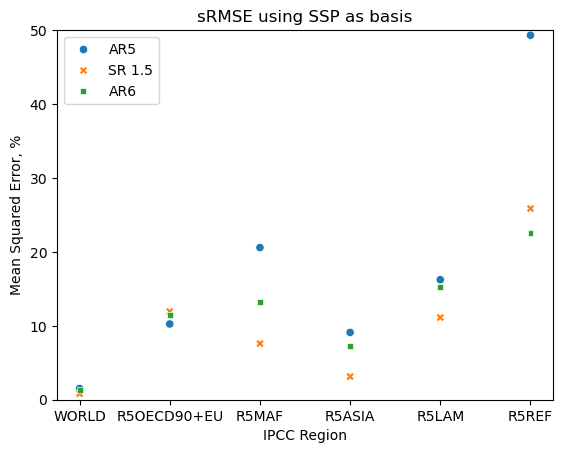

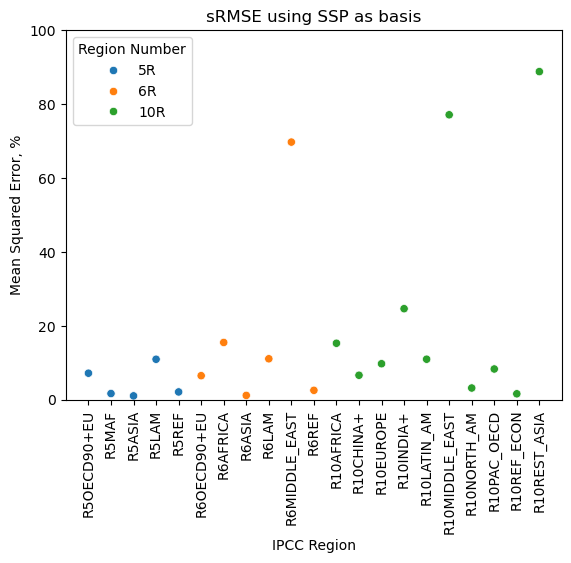

In [43]:
# world
samples = [ar5HIt, ar15HIt, ar6HIt]
datasets = ["AR5", "SR 1.5", "AR6"]
un_databases = [SSPgroups, SSPgroups, SSPgroups]
region = "WORLD"
year = 2020
threshold = (0.005, 0.995)
scaler=1000
untype="SSP"
output = pd.DataFrame()
for s, sample in enumerate(samples):
    dataset = datasets[s]
    samplet = sample.copy(deep=True)
    samplet["IPCCRegion"] = region
    err = np.array(data_error(un_databases[s], 
                                samplet, 
                                year, 
                                threshold, 
                                region, 
                                dataset, 
                                scaler,
                                untype))
    err = err.reshape(1, len(err))
    pderr = pd.DataFrame(err, columns=["MAE", "MSE", "sRMSE"], index=[dataset])
    pderr["IPCCRegion"] = region
    output = pd.concat((output, pderr), axis=0)

outputworld = output.copy(deep=True)
pad = pd.DataFrame(outputworld["sRMSE"].values.reshape(-1,1).transpose(),columns=np.array(["AR5", "SR 1.5", "AR6"]), index=["WORLD"])


# 5 regions
samples = [ar5HI, ar15HI, ar6reg5HI]
datasets = ["AR5", "SR 1.5", "AR6"]
un_databases = [SSPrex5, SSPrex5, SSPrex5]
regions = ['R5OECD90+EU', 'R5MAF', 'R5ASIA', 'R5LAM', 'R5REF']
year = 2020
threshold = (0.001, 0.999)
scaler=1
untype="SSP"
output = pd.DataFrame()
for region in regions:
    newc = pd.DataFrame()
    for s, sample in enumerate(samples):
        samplet = transformAR(sample,region, dataset, threshold, [year], "Population", "Population")
        dataset = datasets[s]
        err = np.array(data_error(un_databases[s], 
                                  samplet, 
                                  year, 
                                  threshold, 
                                  region, 
                                  dataset, 
                                  scaler,
                                  untype))
        err = err.reshape(1, len(err))
        pderr = pd.DataFrame(err, columns=["MAE", "MSE", "sRMSE"], index=[dataset])
        pderr["IPCCRegion"] =region
        output = pd.concat((output, pderr), axis=0)
        new = pd.DataFrame(pderr["sRMSE"].values.reshape(-1,1).transpose(),columns=[dataset], index=[region])
        newc = pd.concat((newc,new), axis=1)
    pad = pd.concat((pad, newc),axis=0)
outputr = output.copy(deep=True)

output = pd.concat((outputworld, outputr), axis=0)
output = output.reset_index()
output.columns = ["IPCC Report", "MAE", "MSE", "sRMSE", "IPCC Region"]

plt.figure (1)
ax=sns.scatterplot(data=pad)
plt.title("sRMSE using SSP as basis")
plt.ylabel("Mean Squared Error, %")
plt.xlabel("IPCC Region")
plt.legend(loc='upper left')
ax.set_ylim(0, 50)
figname = "rmse_allreport_SSP.png"
fig.savefig(os.path.join(path_for_figure, figname), dpi=300)

# 5,6,10 regions
samples = [ar6reg5HI, ar6reg6HI, ar6reg10HI]
datasets = ["5R", "6R", "10R"]
un_databases = [SSPrex5, SSPrex6, SSPrex10]
regions5 = ['R5OECD90+EU',
            'R5MAF', 
            'R5ASIA', 
            'R5LAM', 
            'R5REF']

regions6 = ['R6OECD90+EU',
            'R6AFRICA', 
            'R6ASIA',
            'R6LAM',
            'R6MIDDLE_EAST',
            'R6REF']

regions10 = [  "R10AFRICA",  	"R10CHINA+",	"R10EUROPE",	
               "R10INDIA+",	    "R10LATIN_AM",	"R10MIDDLE_EAST",
               "R10NORTH_AM",	"R10PAC_OECD",	"R10REF_ECON",	"R10REST_ASIA"]

dict_sample = {datasets[0]: regions5,
               datasets[1]: regions6, 
               datasets[2]: regions10}

year = 2020
threshold = (0.25, 0.75)
scaler=1
untype="SSP"
output = pd.DataFrame()
for s, sample in enumerate(samples):
    for region in dict_sample[datasets[s]]:
        newc = pd.DataFrame()
        dataset = datasets[s]
        samplet = transformAR(sample,region, dataset, threshold, [year], "Population", "Population")
        err = np.array(data_error(un_databases[s], 
                                  samplet, 
                                  year, 
                                  threshold, 
                                  region, 
                                  dataset, 
                                  scaler,
                                  untype))
        err = err.reshape(1, len(err))
        pderr = pd.DataFrame(err, columns=["MAE", "MSE", "sRMSE"], index=[dataset])
        pderr["IPCCRegion"] = region
        output = pd.concat((output, pderr), axis=0)
    #     new = pd.DataFrame(pderr["sRMSE"].values.reshape(-1,1).transpose(),columns=[dataset], index=[region])
    #     newc = pd.concat((newc,new), axis=1)
    # pad = pd.concat((pad, newc),axis=0)
outputr = output.copy(deep=True)

output = output.reset_index()
output.columns = ["Region Number", "MAE", "MSE", "sRMSE", "IPCC Region"]


plt.figure(2)
ax=sns.scatterplot(data=output[["Region Number", "sRMSE", "IPCC Region"]], x=output["IPCC Region"], y=output["sRMSE"], hue = output["Region Number"])
plt.ylabel("Mean Squared Error, %")
plt.xticks(rotation = 90)
plt.xlabel("IPCC Region")
plt.title("sRMSE using SSP as basis")
ax.set_ylim(0, 100)
figname = "rmse_allreg_SSP.png"
fig.savefig(os.path.join(path_for_figure, figname), dpi=300)

### Figure 7

Comparison of AR6 against SSPs and density distribution for year 2100

blur


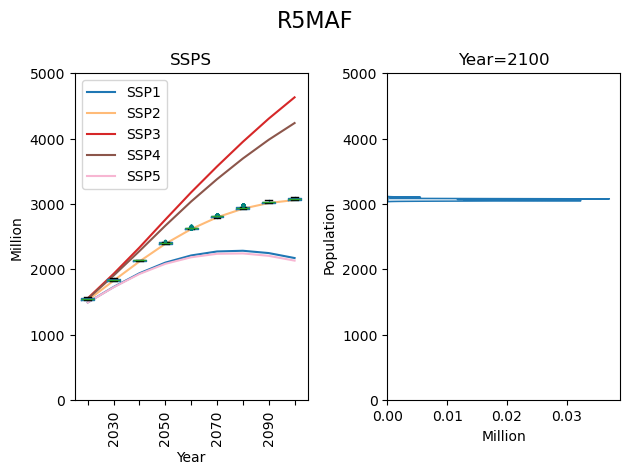

blur


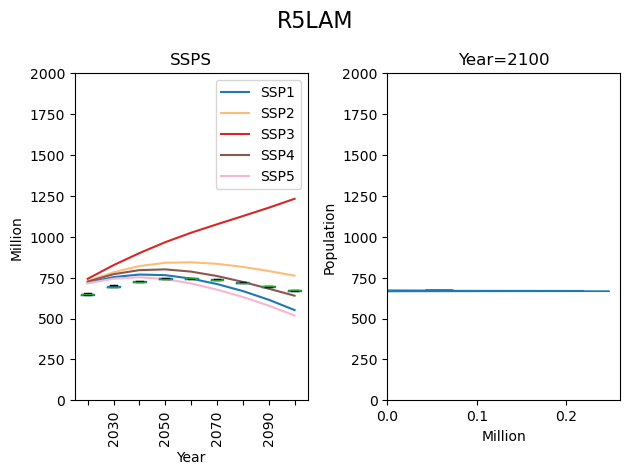

blur


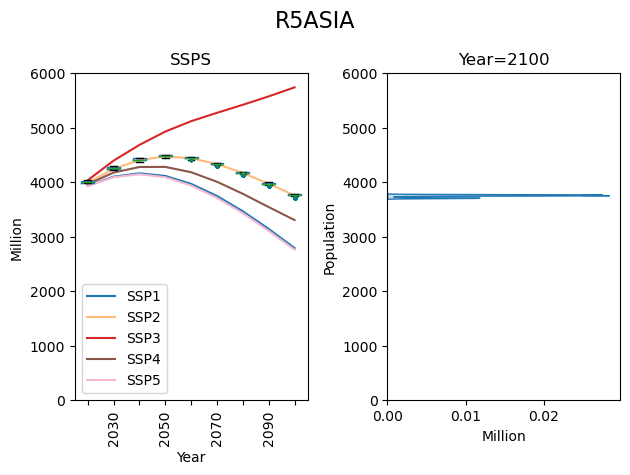

blur


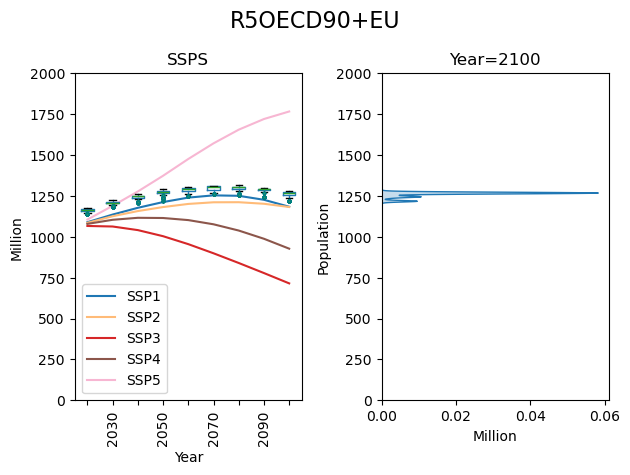

blur


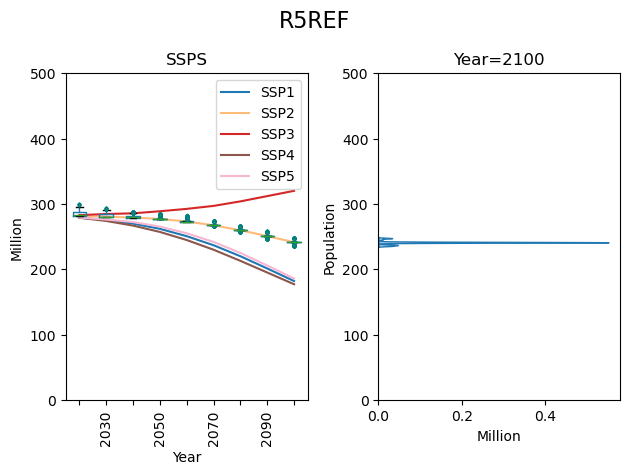

In [44]:
# UN and R10
# regions10 = [
#  'R10LATIN_AM',
#  'R10INDIA+',
#  'R10CHINA+',
#  'R10AFRICA',
#  'R10NORTH_AM']

# regions6 = [
#     "R6AFRICA", 
#     "R6LAM", 
#     "R6ASIA", 
#     "R6OECD90+EU"] 

regions5 = [
    "R5MAF", 
    "R5LAM", 
    "R5ASIA", 
    "R5OECD90+EU",
    "R5REF"] 

limits10 = [1500, 4000, 4000, 4000, 1000]
limits6 = [5000, 2000, 6000, 2000]
limits5 = [5000, 2000, 6000, 2000,500]
lim_dict10=dict(zip(regions10,limits10))
lim_dict6=dict(zip(regions6,limits6))
lim_dict5=dict(zip(regions5,limits5))
threshold = (0.25, 0.75)
# for region in regions10:
#     ar6reg10HIt = transformAR(ar6reg10HI, region, "AR6", threshold, years, "Population", "Population")
#     SSPrex10t = transformSSP(SSPrex10, region, years, "Population")
#     fig = plot_mars(ar6reg10HIt, SSPrex10t.copy(deep=True), region,
#             scenarios2, label_scenarios2,(0,lim_dict10[region]), "Million", years)
#     figname = "MAR" + region + ".png"
#     fig.savefig(os.path.join(path_for_figure, figname), dpi=300)

# for region in regions6:
#     ar6reg6HIt = transformAR(ar6reg6HI, region, "AR6", threshold, years, "Population", "Population")
#     SSPrex6t = transformSSP(SSPrex6, region, years, "Population")
#     fig = plot_mars(ar6reg6HIt, SSPrex6t.copy(deep=True), region,
#             scenarios2, label_scenarios2,(0,lim_dict6[region]), "Million", years)
#     figname = "MAR" + region + ".png"
#     fig.savefig(os.path.join(path_for_figure, figname), dpi=300)

for region in regions5:
    ar6reg5HIt = transformAR(ar6reg5HI, region, "AR6", threshold, years, "Population", "Population")
    SSPrex5t = transformSSP(SSPrex5, region, years, "Population")
    fig = plot_mars(ar6reg5HIt, SSPrex5t.copy(deep=True), region,
            scenarios2, label_scenarios2,(0,lim_dict5[region]), "Million", years)
    figname = "MAR" + region + ".png"
    fig.savefig(os.path.join(path_for_figure, figname), dpi=300)


### Figure 15 (a, b, c, d, e, f) in Methods

Note that here charts refer to each single region belonging to the IPCC breakdown

In the paper a selection is made for those allowing a more reasonable comparison with UN 

Therefore, this section contains more figures than those reported in the paper

Comparing AR6 with SSP and UN using 5 regions

blur


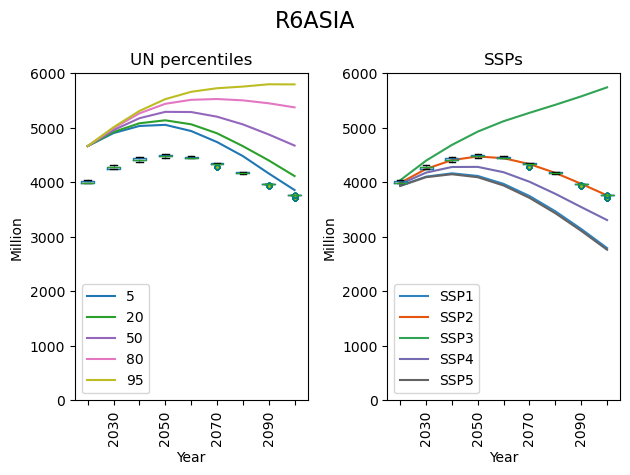

blur


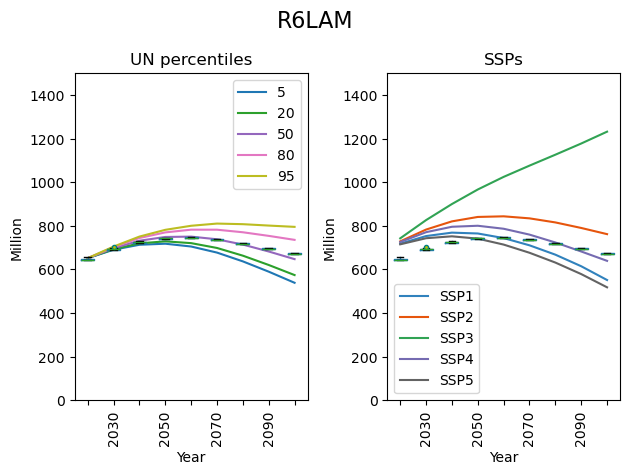

blur


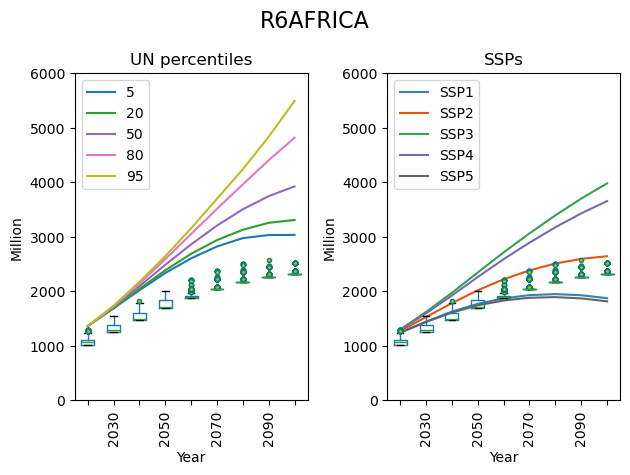

In [45]:
regions=["R6ASIA", "R6LAM", "R6AFRICA"] 
limits = [6000, 1500, 6000]
lim_dict=dict(zip(regions,limits))

scenarios1 = ["5", "20", "50", "80", "95"]
label_scenarios1 = [
                    "5", 
                    "20", 
                    "50", 
                    "80", 
                    "95",
                  
]
scenarios2 = ["SSP1", "SSP2", "SSP3", "SSP4", "SSP5"]
label_scenarios2 = [ "SSP1",
                    "SSP2", 
                    "SSP3", 
                    "SSP4", 
                    "SSP5",]

threshold = (0.25, 0.75)

for region in regions:
    ar6reg6HIt = transformAR(ar6reg6HI, region, "AR6", threshold, years, "Population", "Population")
    r2022_6t = transformUN(r2022_6, region, True)
    SSPrex6t = transformSSP(SSPrex6, region, years, "Population")
    plot_ars(ar6reg6HIt, r2022_6t.copy(deep=True), SSPrex6t.copy(deep=True), region,
            scenarios1, label_scenarios1, scenarios2, label_scenarios2, (0,lim_dict[region]), "Million", years)
    figname = "UN" + region + ".png"
    fig.savefig(os.path.join(path_for_figure, figname), dpi=300)

Comparing AR6 with SSP and UN using 10 regions

blur


<Figure size 640x480 with 0 Axes>

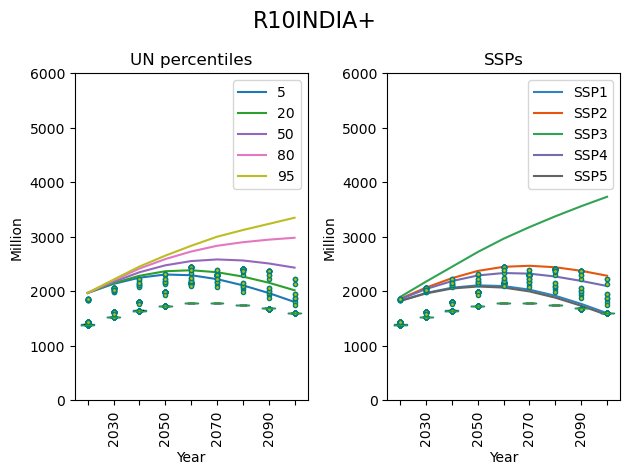

blur


<Figure size 640x480 with 0 Axes>

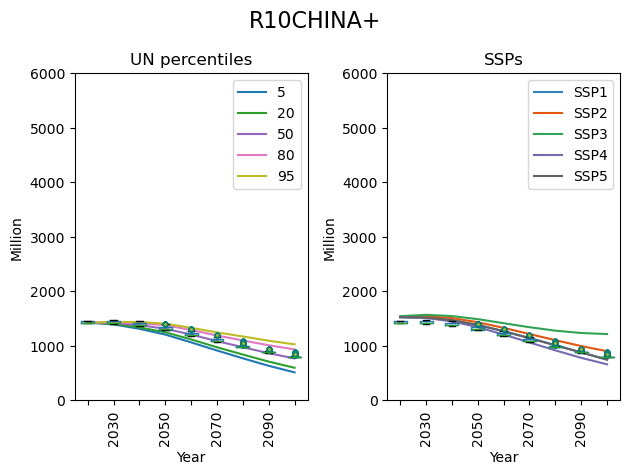

blur


<Figure size 640x480 with 0 Axes>

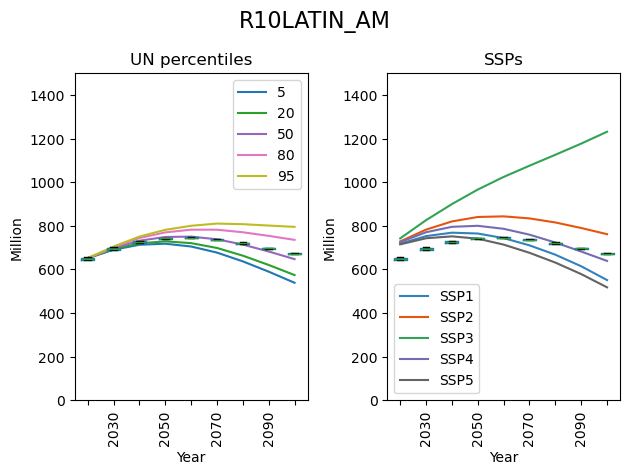

blur


<Figure size 640x480 with 0 Axes>

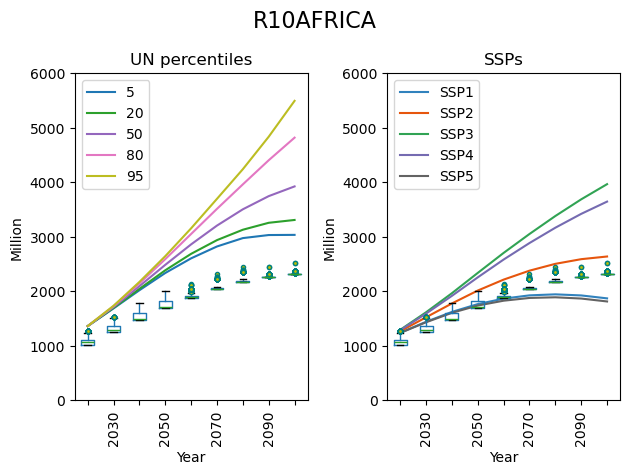

In [56]:
# UN and R10
regions = [
 'R10INDIA+',
 'R10CHINA+',
 'R10LATIN_AM',
 'R10AFRICA',
]

limits = [6000, 6000, 1500, 6000]
lim_dict=dict(zip(regions,limits))
threshold = (0.25, 0.75)
for r, region in enumerate(regions):
    fig = plt.figure(r)
    ar6reg10HIt = transformAR(ar6reg10HI, region, "AR6", threshold, years, "Population", "Population")
    r2022_10t = transformUN(r2022_10, region, True)
    SSPrex10t = transformSSP(SSPrex10, region, years, "Population")
    plot_ars(ar6reg10HIt, r2022_10t.copy(deep=True), SSPrex10t.copy(deep=True), region,
            scenarios1, label_scenarios1, scenarios2, label_scenarios2, (0,lim_dict[region]), "Million", years)
    figname = "UN" + region + ".png"
    fig.savefig(os.path.join(path_for_figure, figname), dpi=300)

blur


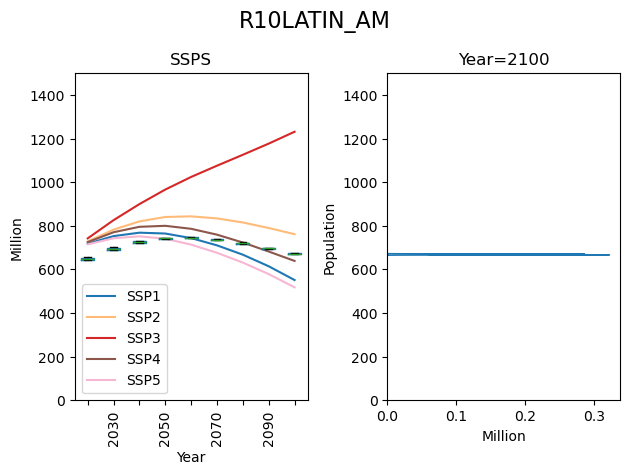

blur


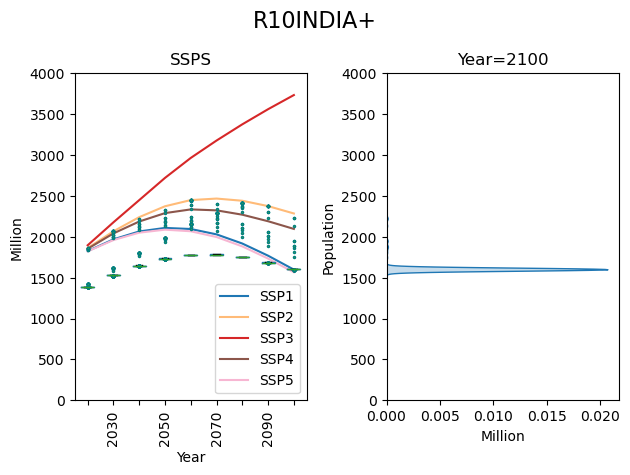

blur


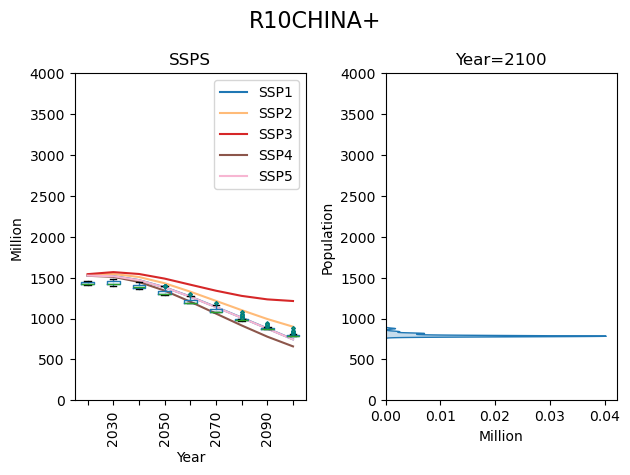

blur


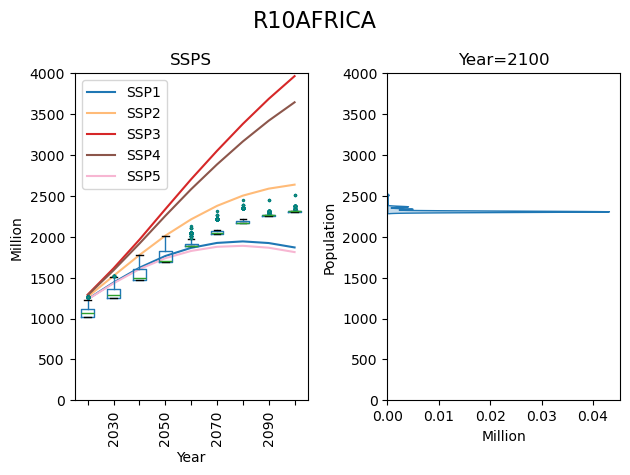

blur


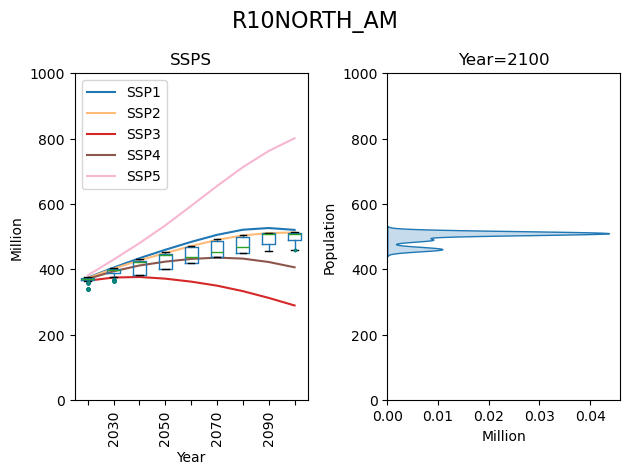

blur


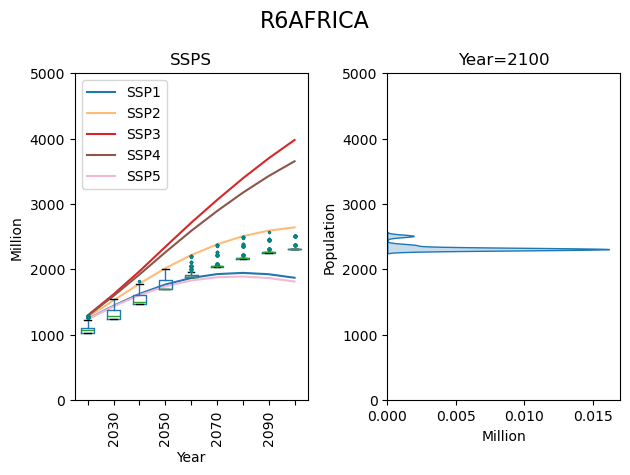

blur


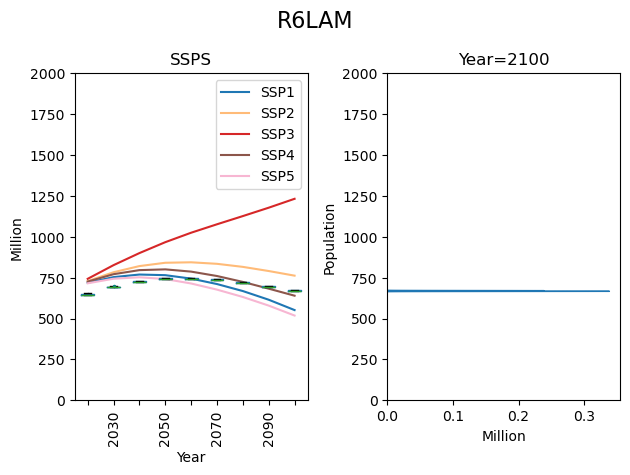

blur


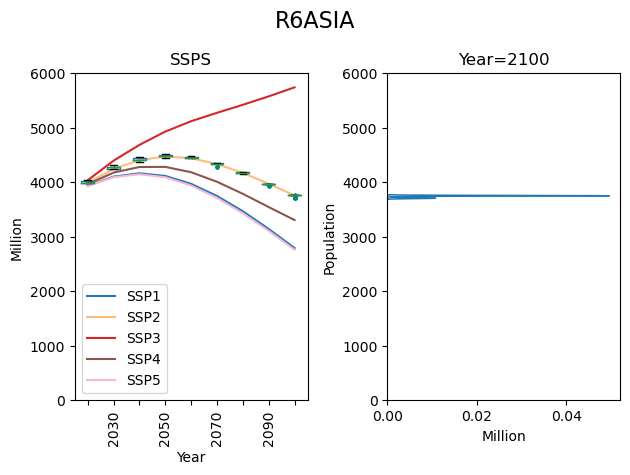

blur


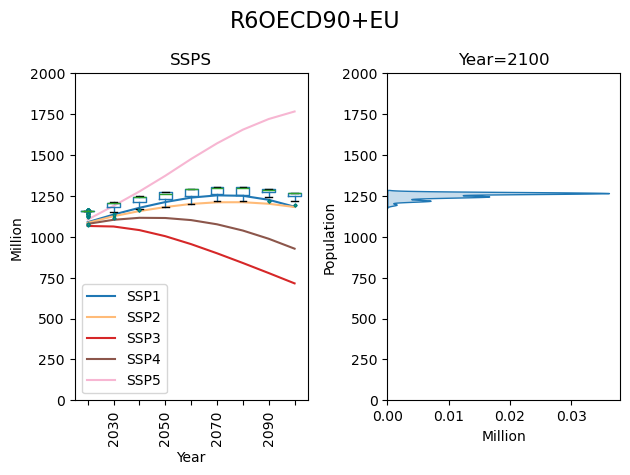

blur


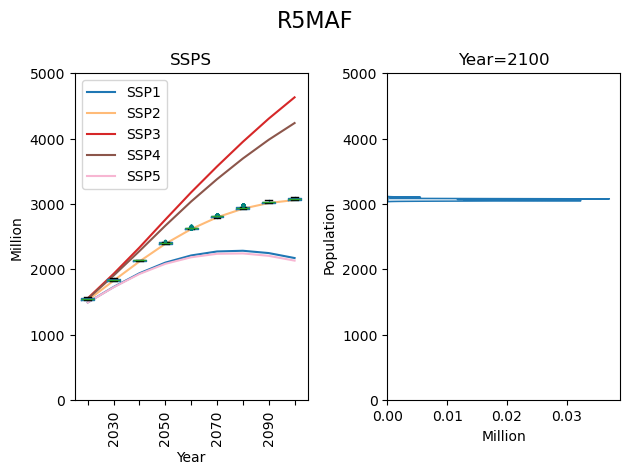

blur


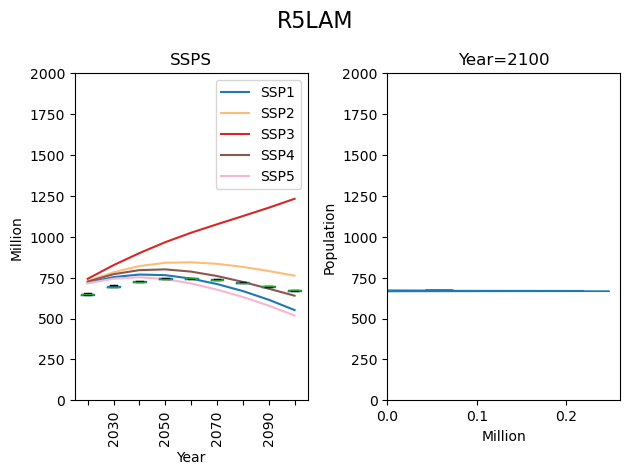

blur


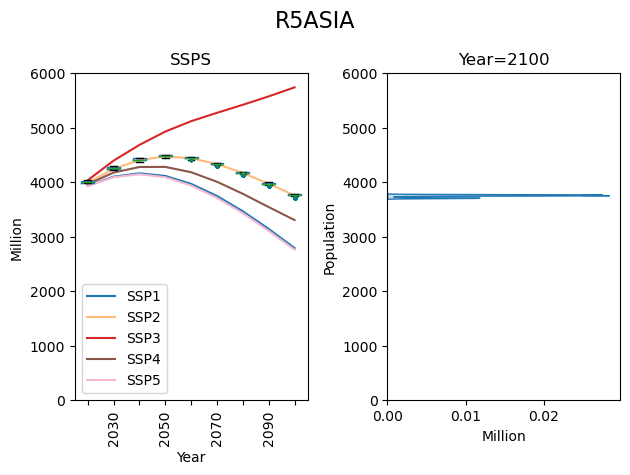

blur


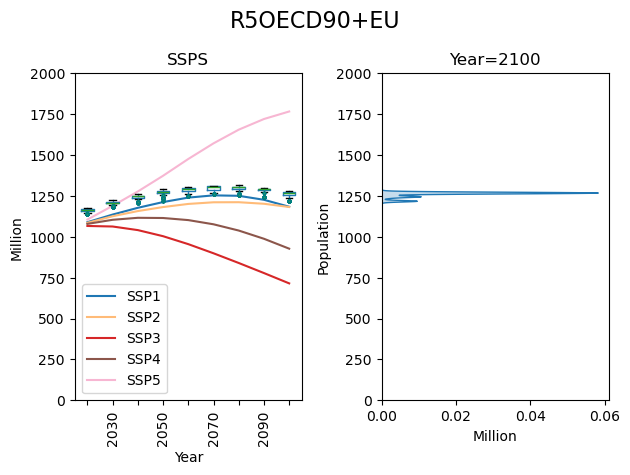

blur


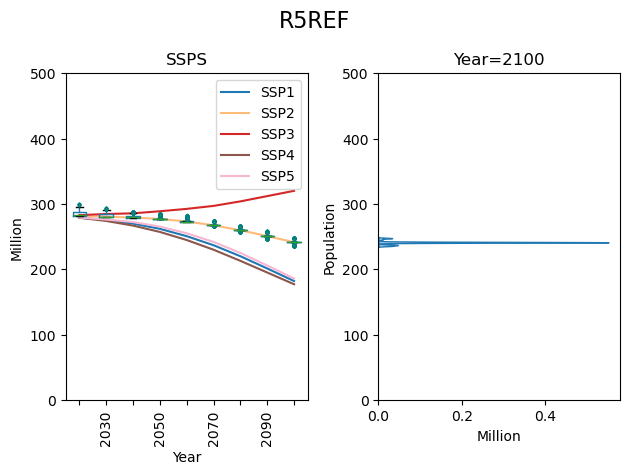

In [49]:
# UN and R10
regions10 = [
 'R10LATIN_AM',
 'R10INDIA+',
 'R10CHINA+',
 'R10AFRICA',
 'R10NORTH_AM']

regions6 = [
    "R6AFRICA", 
    "R6LAM", 
    "R6ASIA", 
    "R6OECD90+EU"] 

regions5 = [
    "R5MAF", 
    "R5LAM", 
    "R5ASIA", 
    "R5OECD90+EU",
    "R5REF"] 

limits10 = [1500, 4000, 4000, 4000, 1000]
limits6 = [5000, 2000, 6000, 2000]
limits5 = [5000, 2000, 6000, 2000,500]
lim_dict10=dict(zip(regions10,limits10))
lim_dict6=dict(zip(regions6,limits6))
lim_dict5=dict(zip(regions5,limits5))
threshold = (0.25, 0.75)
for region in regions10:
    ar6reg10HIt = transformAR(ar6reg10HI, region, "AR6", threshold, years, "Population", "Population")
    SSPrex10t = transformSSP(SSPrex10, region, years, "Population")
    fig = plot_mars(ar6reg10HIt, SSPrex10t.copy(deep=True), region,
            scenarios2, label_scenarios2,(0,lim_dict10[region]), "Million", years)
    figname = "MAR" + region + ".png"
    fig.savefig(os.path.join(path_for_figure, figname), dpi=300)

for region in regions6:
    ar6reg6HIt = transformAR(ar6reg6HI, region, "AR6", threshold, years, "Population", "Population")
    SSPrex6t = transformSSP(SSPrex6, region, years, "Population")
    fig = plot_mars(ar6reg6HIt, SSPrex6t.copy(deep=True), region,
            scenarios2, label_scenarios2,(0,lim_dict6[region]), "Million", years)
    figname = "MAR" + region + ".png"
    fig.savefig(os.path.join(path_for_figure, figname), dpi=300)

for region in regions5:
    ar6reg5HIt = transformAR(ar6reg5HI, region, "AR6", threshold, years, "Population", "Population")
    SSPrex5t = transformSSP(SSPrex5, region, years, "Population")
    fig = plot_mars(ar6reg5HIt, SSPrex5t.copy(deep=True), region,
            scenarios2, label_scenarios2,(0,lim_dict5[region]), "Million", years)
    figname = "MAR" + region + ".png"
    fig.savefig(os.path.join(path_for_figure, figname), dpi=300)


## Part 6: Supplementary material

### Figure 10-17

<Figure size 640x480 with 0 Axes>

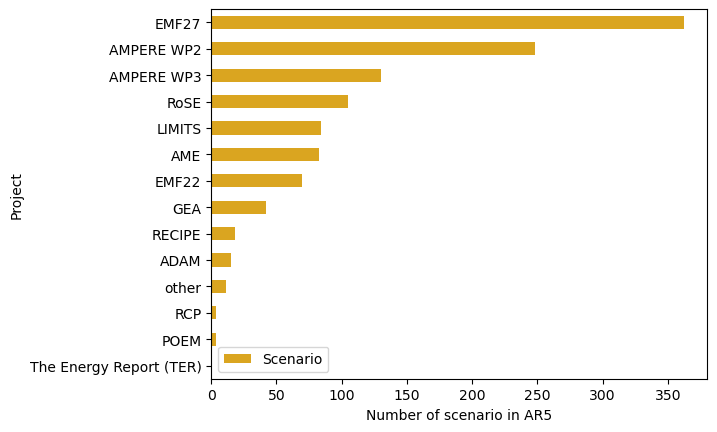

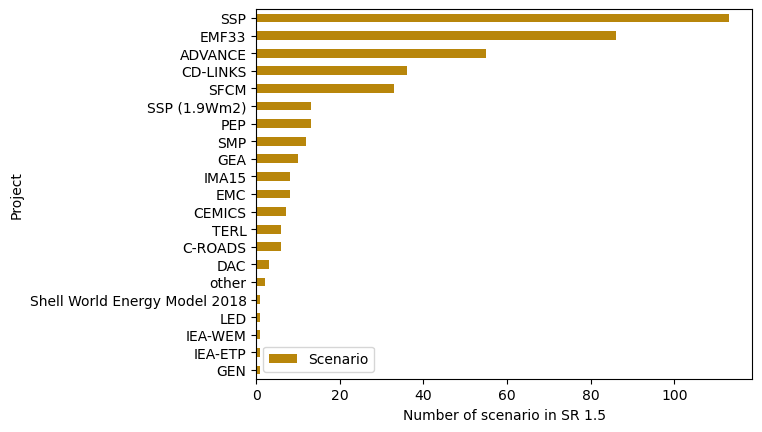

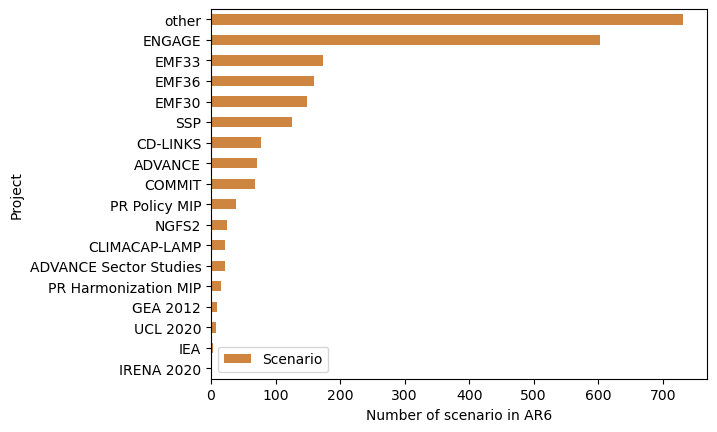

In [45]:
ar_scenarios, ar5meta, ar15meta, ar6meta = readmeta("data")
srdbases = ["AR5", "SR 1.5", "AR6"]
srdnames = ["AR5", "SR1.5", "AR6"]
colours = [ "goldenrod", "darkgoldenrod", "peru"]
for f, fsr in enumerate(srdbases):
    ar = pd.DataFrame(ar_scenarios.loc[ar_scenarios.Report==fsr]).drop("Report", axis=1)
    projects = ar["Project"].transpose()
    ar = ar.reset_index().set_index(projects).drop("index", axis=1)
    plt.figure(f+2)
    ar.plot.barh(color=colours[f])
    xlabel = ["Number of scenario in " + fsr]
    plt.xlabel(xlabel[0])
    figname = "project" + srdnames[f] + ".png"
    fig.savefig(os.path.join(path_for_figure, figname), dpi=300)

### Figures 12, 14, 16
Scenario counts by model

<Figure size 640x480 with 0 Axes>

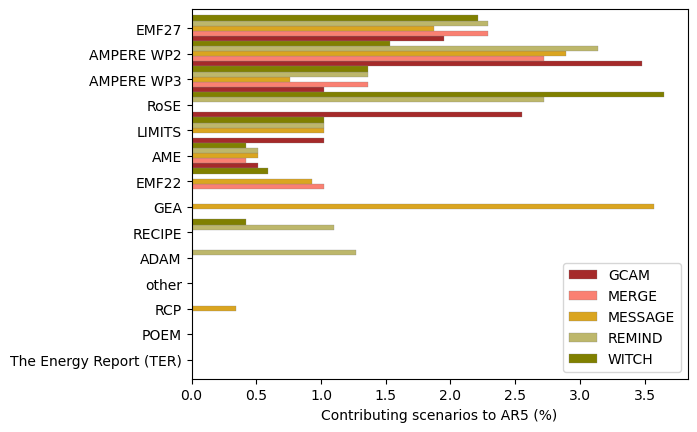

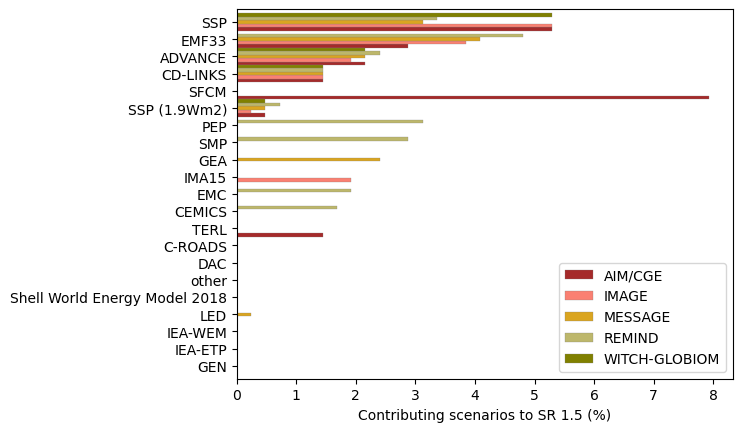

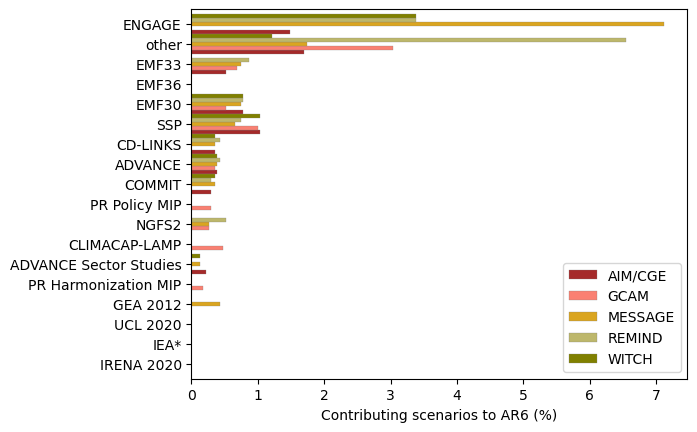

In [46]:

colours = ["brown", "salmon", "goldenrod", "darkkhaki", "olive"]
srdbases = ["AR5", "SR 1.5", "AR6"]

top5full = [["GCAM", "MERGE", "MESSAGE", "REMIND", "WITCH"],
            ["AIM/CGE", "IMAGE", "MESSAGE", "REMIND", "WITCH-GLOBIOM"],
            ["AIM/CGE", "GCAM", "MESSAGE", "REMIND", "WITCH"]]
metadbases = [ar5meta, ar15meta, ar6meta]
for f, fsr in enumerate(srdbases): 
    top5 = top5full[f]
    arsel = pd.DataFrame(metadbases[f][metadbases[f]["Model"].isin(top5)]).drop("Report", axis=1).transpose()
    rename_dict = dict(zip(arsel.columns,top5))
    arselt = arsel[1:].rename(columns=rename_dict)
    plt.figure(f)
    arselt.plot.barh(color=colours, linewidth=0.2, edgecolor="gray", width=1.0)
    xlabel = ["Contributing scenarios to " + fsr + " (%)"]
    plt.xlabel(xlabel[0])
    figname = "modproject" + srdnames[f] + ".png"
    fig.savefig(os.path.join(path_for_figure, figname), dpi=300)